# **Bitcoin's Volatility Forecast and Application**

Applied Finance Project - Group 2

File Objective: Data, Model, Volatility Prediction, and Application

Last review: 2024-04-25

Author: APF GROUP 2

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from math import log, sqrt, pi, exp
from datetime import datetime, date, timedelta

%matplotlib inline

In [ ]:
import yfinance as yf

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# **Dataset Description and Processing**

## **Dataset**

The historical dataset of Bitcoin Open/Close/High/Low prices were obtained using the Yahoo Finance API yfinance. This API is free, very easy to set up, but yet still contains a wide range of data and offerings.

We will download BTC-USD prices using ticker BTC-USD at 1-day interval. Yahoo did not add Bitcoin until 2014; and therefore although it was first traded in 2009, yfinance only contains data from September 2014 until now (August 2021). I would therefore be working with over 3485 datapoints covering about 9 years of trading days.

In [ ]:
start = datetime(2014, 1, 1)
end = datetime.today()

tckr = 'BTC-USD'
ticker = yf.Ticker(tckr)

df = ticker.history(start=start,
                    end=end,
                    interval="1d")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3524 entries, 2014-09-17 00:00:00+00:00 to 2024-05-10 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3524 non-null   float64
 1   High          3524 non-null   float64
 2   Low           3524 non-null   float64
 3   Close         3524 non-null   float64
 4   Volume        3524 non-null   int64  
 5   Dividends     3524 non-null   float64
 6   Stock Splits  3524 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 220.2 KB


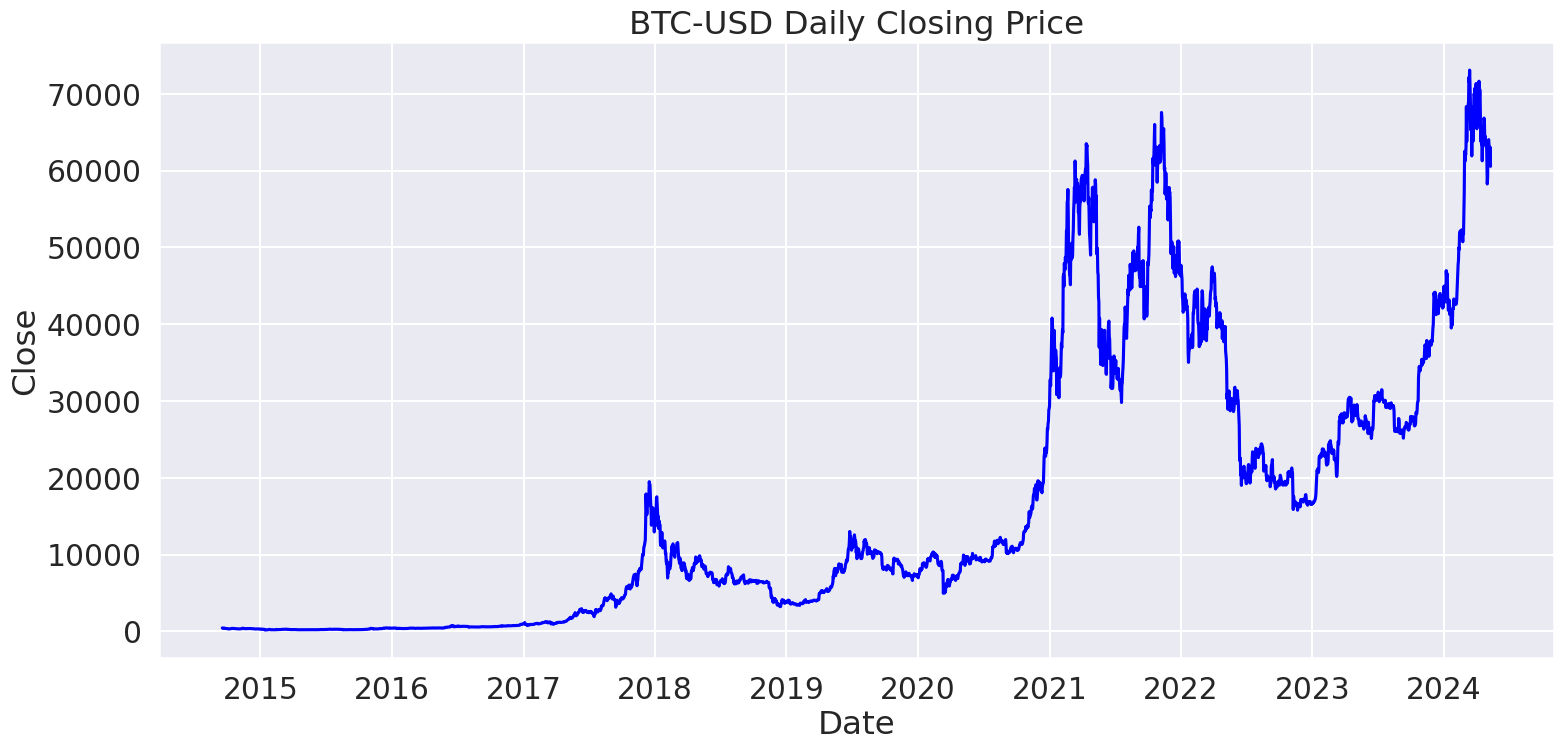

In [ ]:
# CHANGE CONTEXT TO poster TO INCREASE FONT SIZES
sns.set_context("talk", font_scale=1.3)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('BTC-USD Daily Closing Price')

Further research indicates that for practicality purposes it's preferable to use the log returns especially in mathematic modeling, because it helps eliminate non-stationary properties of time series data, and makes it more stable:


**Log returns formula:**

$r_{t, t+i} = log(P_{t+i} / P_{t})$

There's another advantage to log returns, which is that they're additive across time: $r_{t1, t2} + r_{t2, t3} = r_{t1, t3}$

In [ ]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

# FORMAT ADJUSTMENT ADN DROP FIRST RAW OF DATA
df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
df.index = df.index.strftime('%Y-%m-%d')
df.index = pd.to_datetime(df.index)
df.dropna(inplace=True) # The raw for the first date 2014.09.17 is droped

df.tail()

Open          High           Low         Close  \
Date                                                                 
2024-05-06  64038.312500  65494.902344  62746.238281  63161.949219   
2024-05-07  63162.761719  64390.457031  62285.980469  62334.816406   
2024-05-08  62332.640625  62986.085938  60877.128906  61187.941406   
2024-05-09  61191.199219  63404.914062  60648.074219  63049.960938   
2024-05-10  63061.996094  63437.750000  60317.429688  60558.226562   

                 Volume   returns  log_returns  
Date                                            
2024-05-06  28697928697 -1.357439    -0.013667  
2024-05-07  25930730982 -1.309543    -0.013182  
2024-05-08  26088172222 -1.839863    -0.018570  
2024-05-09  25453338161  3.043115     0.029977  
2024-05-10  28716187648 -3.952000    -0.040322

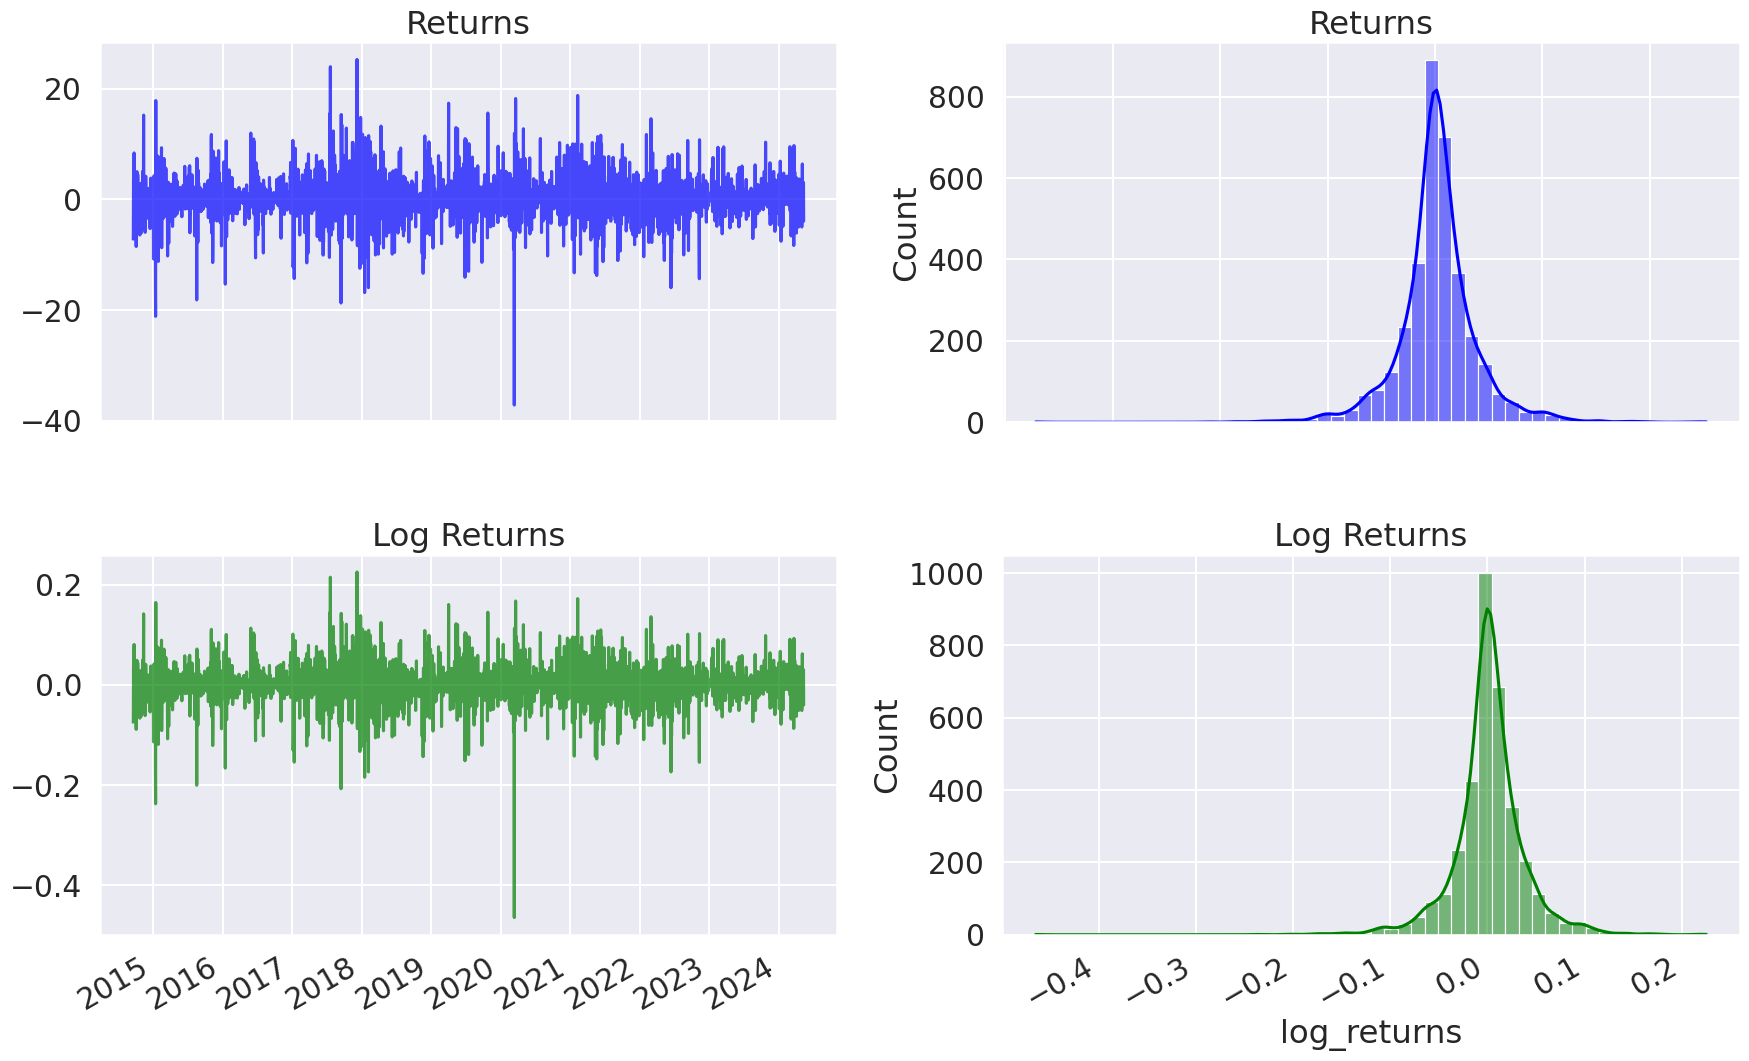

In [ ]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue', alpha=0.7)
    axes[0][0].set_title('Returns')

    sns.histplot(df.returns, color='blue',
                bins=50, ax=axes[0][1], kde=True)
    axes[0][1].set_title('Returns')

    axes[1][0].plot(df.log_returns, color='green', alpha=0.7)
    axes[1][0].set_title('Log Returns')

    sns.histplot(df.log_returns, color='green',
                bins=50, ax=axes[1][1], kde=True)
    axes[1][1].set_title('Log Returns')

    plt.tight_layout()
    fig.autofmt_xdate()
    plt.show();

Both Returns & Log Returns show some:

*   slight negative skewness
*   positive kurtosis (leptokurtic) - higher peak with thicker tails than the standard normal distribution.


In [ ]:
# SHOW RETURN DATA DESCRIPTION
returns_summary = df['returns'].describe()
log_returns_summary = df['log_returns'].describe()
summary_table = pd.concat([returns_summary, log_returns_summary], axis=1)
summary_table.columns = ['Returns', 'Log Returns']

print(summary_table)

           Returns  Log Returns
count  3523.000000  3523.000000
mean      0.206979     0.001387
std       3.677567     0.037054
min     -37.169539    -0.464730
25%      -1.250888    -0.012588
50%       0.139112     0.001390
75%       1.719608     0.017050
max      25.247169     0.225119


## **Historical Volatility Calculation**

We selected 30 days because 7 days seems too noisy to observe meaningful patterns, while longer intervals seem to smooth the volatility down significantly and tend to revert back to the mean.

Using interval window of 30 days would also help avoid wasting too many datapoints at the beginning of the dataset.

Time-series forecasting models are the models that are capable to predict future values based on previously observed values. Target "future" data in this case is obtained by shifting the current volatility backward by the number of n_future lags.

For example, respected to last week's Monday, this week's Monday is the "future"; therefore I just need to shift the volatility this week back by 7 days, and use it as the desired "future" output for last week.

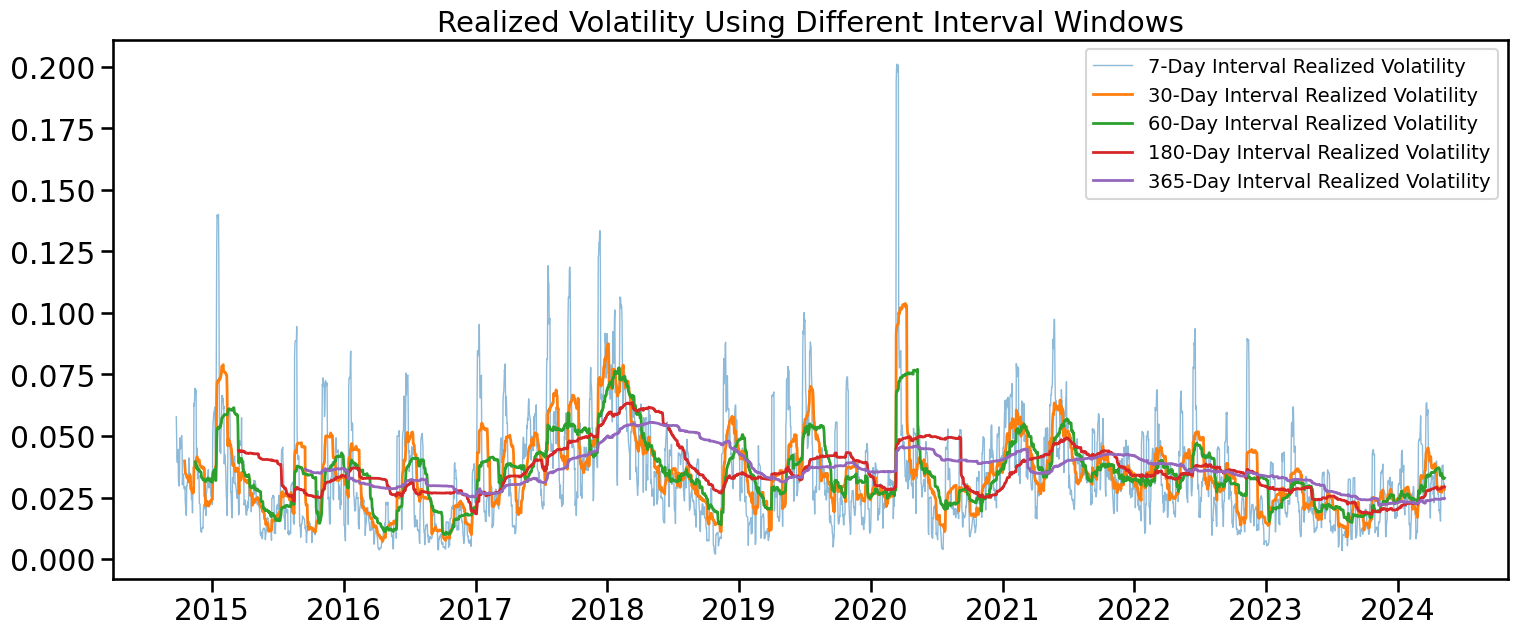

In [ ]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM DAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))


intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

# CHANGING MATPLOTLIB STYLE
fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility',
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})
plt.show();

In [ ]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [ ]:
df.tail(10)

Open          High           Low         Close  \
Date                                                                 
2024-05-01  60609.496094  60780.500000  56555.292969  58254.011719   
2024-05-02  58253.703125  59602.296875  56937.203125  59123.433594   
2024-05-03  59122.300781  63320.503906  58848.312500  62889.835938   
2024-05-04  62891.031250  64494.957031  62599.351562  63891.472656   
2024-05-05  63892.453125  64610.890625  62955.304688  64031.132812   
2024-05-06  64038.312500  65494.902344  62746.238281  63161.949219   
2024-05-07  63162.761719  64390.457031  62285.980469  62334.816406   
2024-05-08  62332.640625  62986.085938  60877.128906  61187.941406   
2024-05-09  61191.199219  63404.914062  60648.074219  63049.960938   
2024-05-10  63061.996094  63437.750000  60317.429688  60558.226562   

                 Volume   returns  log_returns  vol_current  vol_future  
Date                                                                     
2024-05-01  48439780271 -3.929695    -0.040090     0.029361    0.028241  
2024-05-02  32711813559  1.492467     0.014814     0.027071    0.028023  
2024-05-03  33172023048  6.370405     0.061757     0.029361    0.028749  
2024-05-04  20620477992  1.592685     0.015801     0.028670         NaN  
2024-05-05  18296164805  0.218590     0.002184     0.028614         NaN  
2024-05-06  28697928697 -1.357439    -0.013667     0.028582         NaN  
2024-05-07  25930730982 -1.309543    -0.013182     0.028659         NaN  
2024-05-08  26088172222 -1.839863    -0.018570     0.028241         NaN  
2024-05-09  25453338161  3.043115     0.029977     0.028023         NaN  
2024-05-10  28716187648 -3.952000    -0.040322     0.028749         NaN

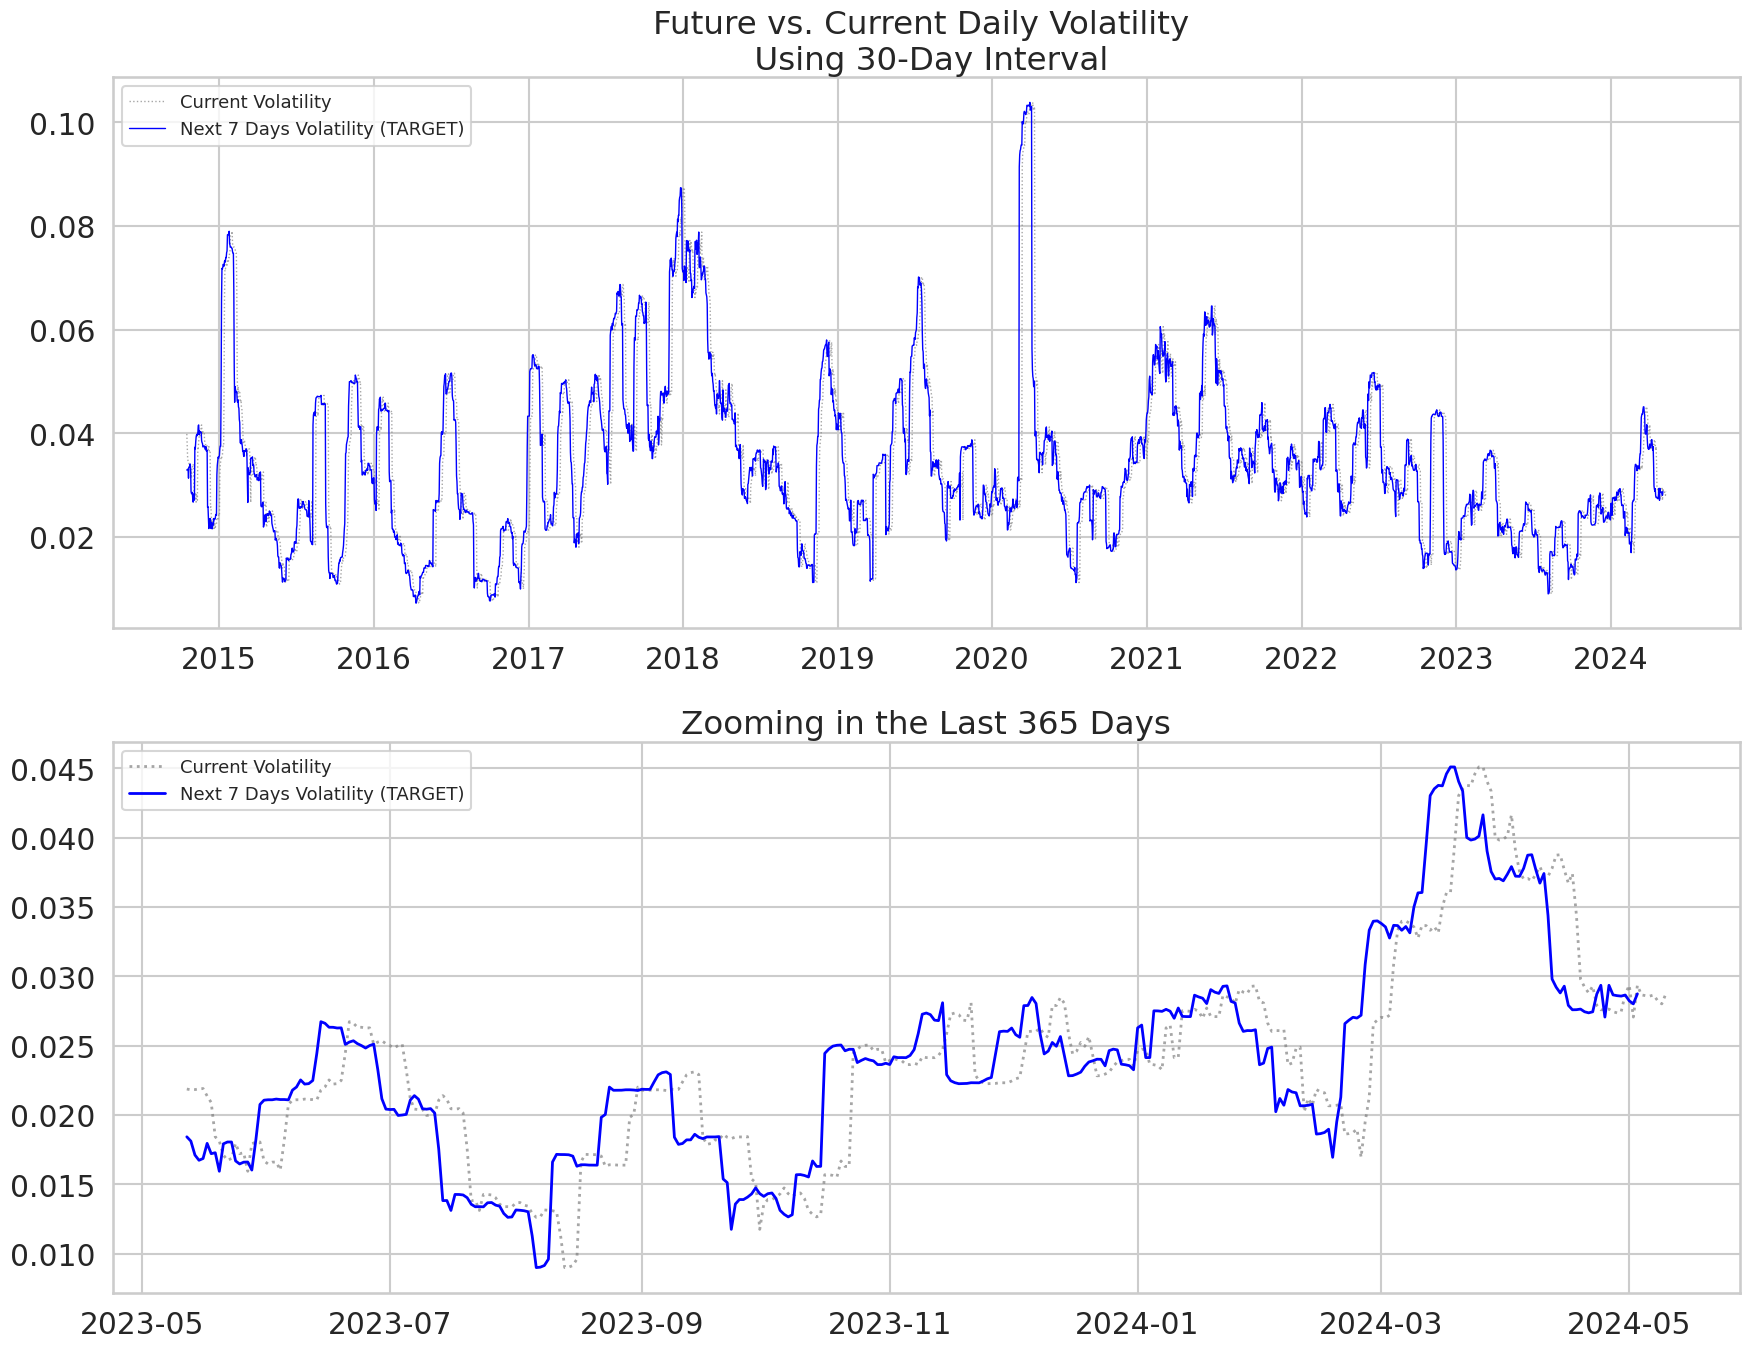

In [ ]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, alpha=0.7, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df.vol_current[-n_zoom:], alpha=0.7, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df.vol_future[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()
    plt.show();

In the plot above, the blue line indicates the target future value that I ultimately try to match up to.

And the dotted gray line represents the current volatility in real-time.

This is a visualization of how current volatility is shifted backward to become future values, which I want to eventually aim for.

## **Daily Volatility Distribution**

<ipython-input-111-1d71e0d79c1f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,


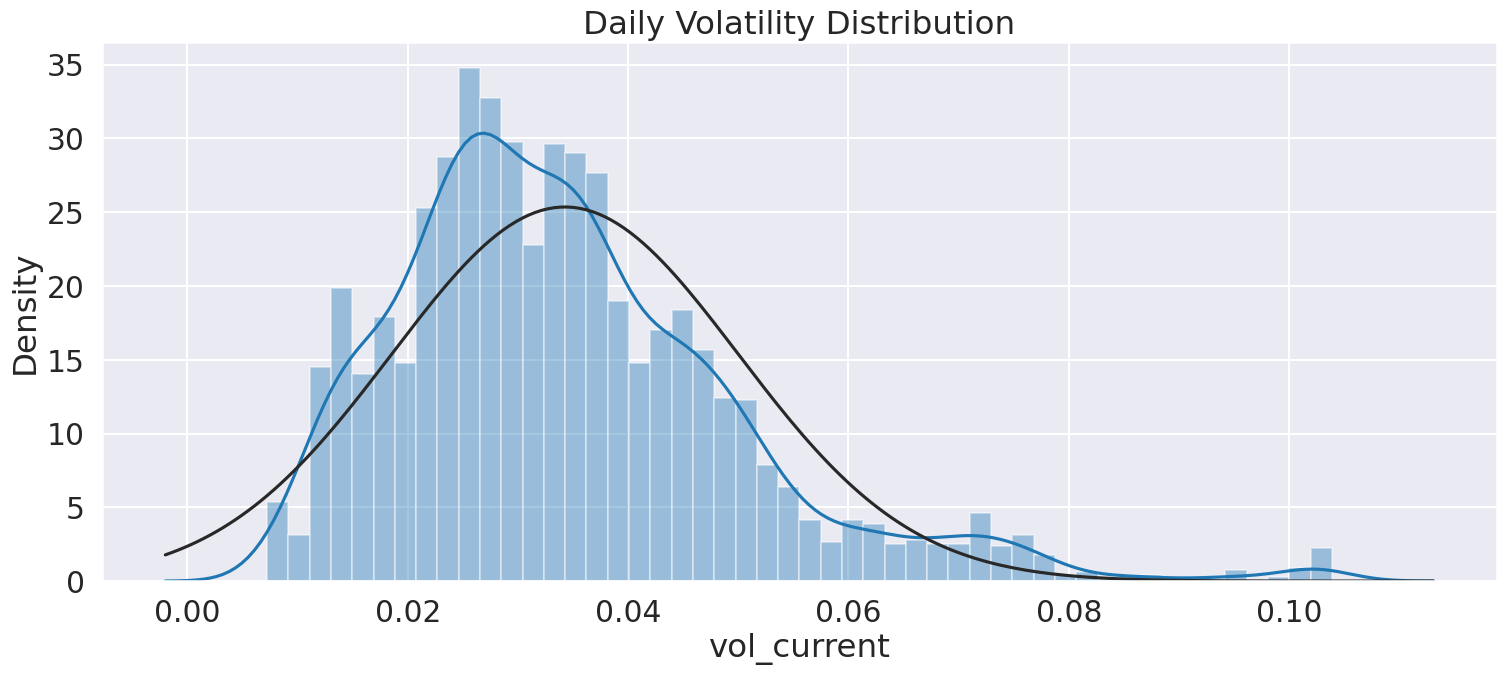

In [ ]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')
    plt.show();

The distribution of daily realized volatility is slightly right skewed, with a small number of large value in the right tail.

Mode< Median< Mean

## **Train-Validation-Test Splits**

Since cryptocurrencies are not traded on a regulated exchange, the Bitcoin market is open 24/7, 1 year covers a whole 365 trading days instead of 252 days a year like with other stocks and commodities.

We would split the dataset into 3 parts as follows:
- the most recent 30 usable datapoints would be used for **Final Model Testing - approx. 0.9%**
- 1 full year (365 days) for **Validation** and **model tuning** during training **- approx. 10.5%**
- and the remaining for **Training - approx. 88.6%**

In [ ]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [ ]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2014-09-18 00:00:00 	to: 2023-04-11 00:00:00 	3128 days
VALIDATION 	From: 2023-04-12 00:00:00 	to: 2024-04-10 00:00:00 	365 days
TEST 		From: 2024-04-11 00:00:00 	to: 2024-05-10 00:00:00 	30 days


In [ ]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

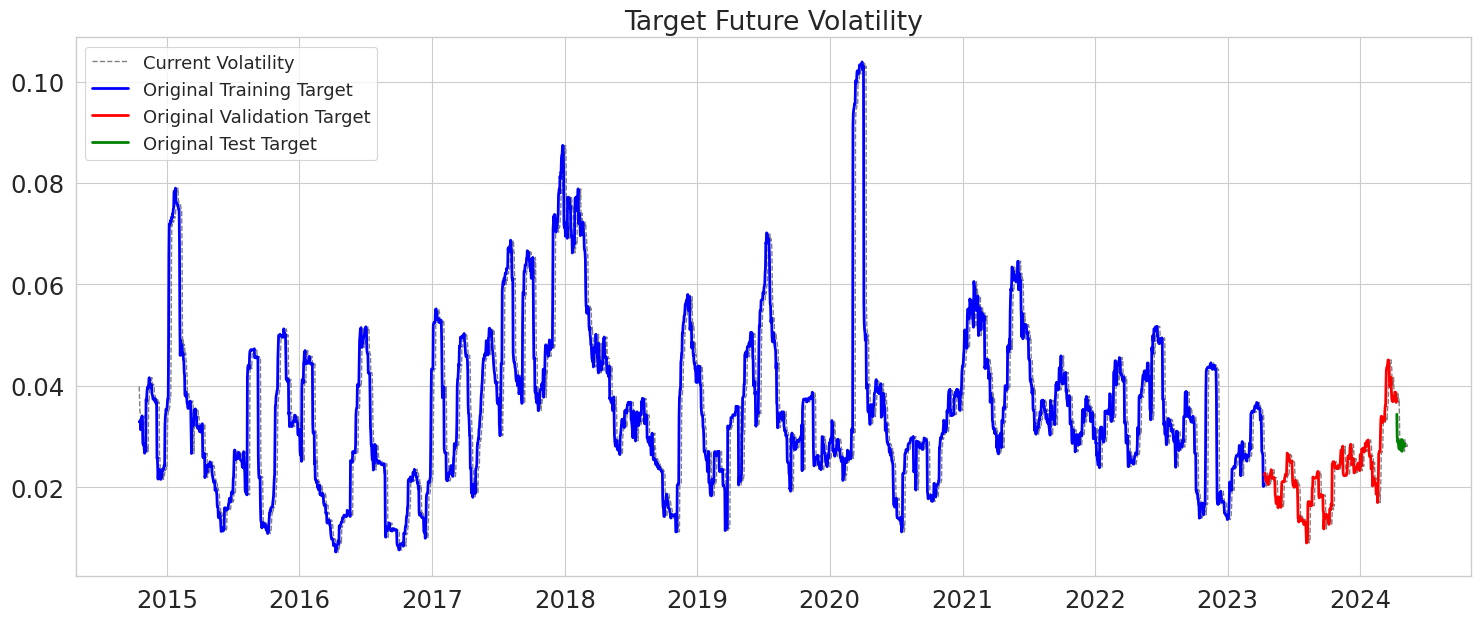

In [ ]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(18,7))

    ax.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax.plot(y_val, color='red', label='Original Validation Target', lw=2)
    ax.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax.title.set_text('Target Future Volatility')
    ax.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.show();

## **Data Scaling**

In [ ]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [ ]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

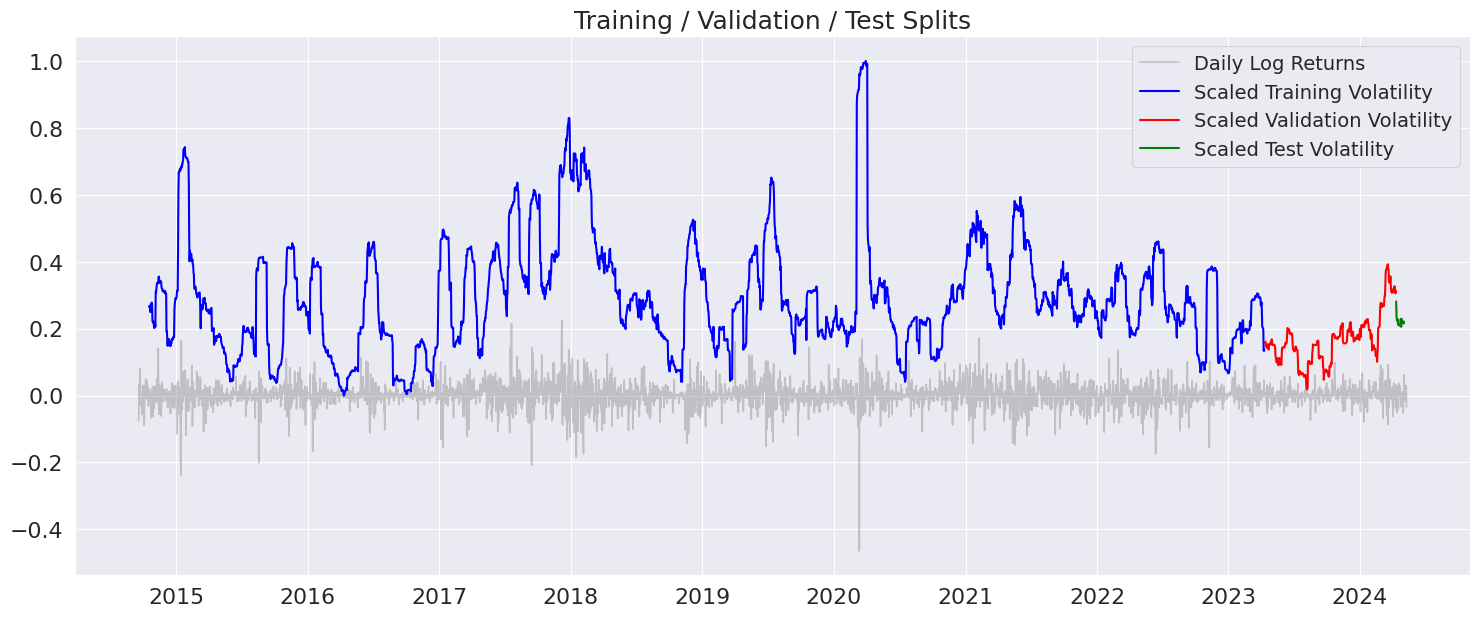

In [ ]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue',
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red',
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green',
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=18)
    plt.legend(prop={'size': 14}, frameon=True)
    plt.show();

## **Performance Metrics**

Usually with financial time series, if we just shift through the historic data trying different methods, parameters and timescales, it's almost certain to find to some strategy with in-sample profitability at some point. However the whole purpose of "forecasting" is to predict the future based on currently available information, and a model that performs best on training data might not be the best when it comes to out-of-sample generalization (or **overfitting**). Avoiding/Minimizing overfitting is even more important in the constantly evolving financial markets where the stake is high.

The 2 main metrics I'd be using are **RMSPE (Root Mean Squared Percentage Error)** and **RMSE (Root Mean Square Errors)** with RMSPE prioritized. Timescaling is very important in the calculation of volatility due to the level of freedom in frequency/interval window selection. Therefore I think RMSPE would help capture degree of errors compared to desired target values better than other metrics. Also RMSPE would punish large errors more than regular MAPE (Mean Absolute Percentage Error), which is what I want to do here.

RMSE and RMSPE would be tracked across different models' performance on validation set forecasting to indicate their abilities to generalize on out-of-sample data.

In [ ]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [ ]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [ ]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [ ]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name,
                                       RMSPE(y_true, y_pred),
                                       RMSE(y_true, y_pred)]
    return perf_df

In [ ]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):

    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")

        plt.plot(y_true, color='blue', lw=2,
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')

        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

# **Model #1: 7-day Rolling Average Forecast**

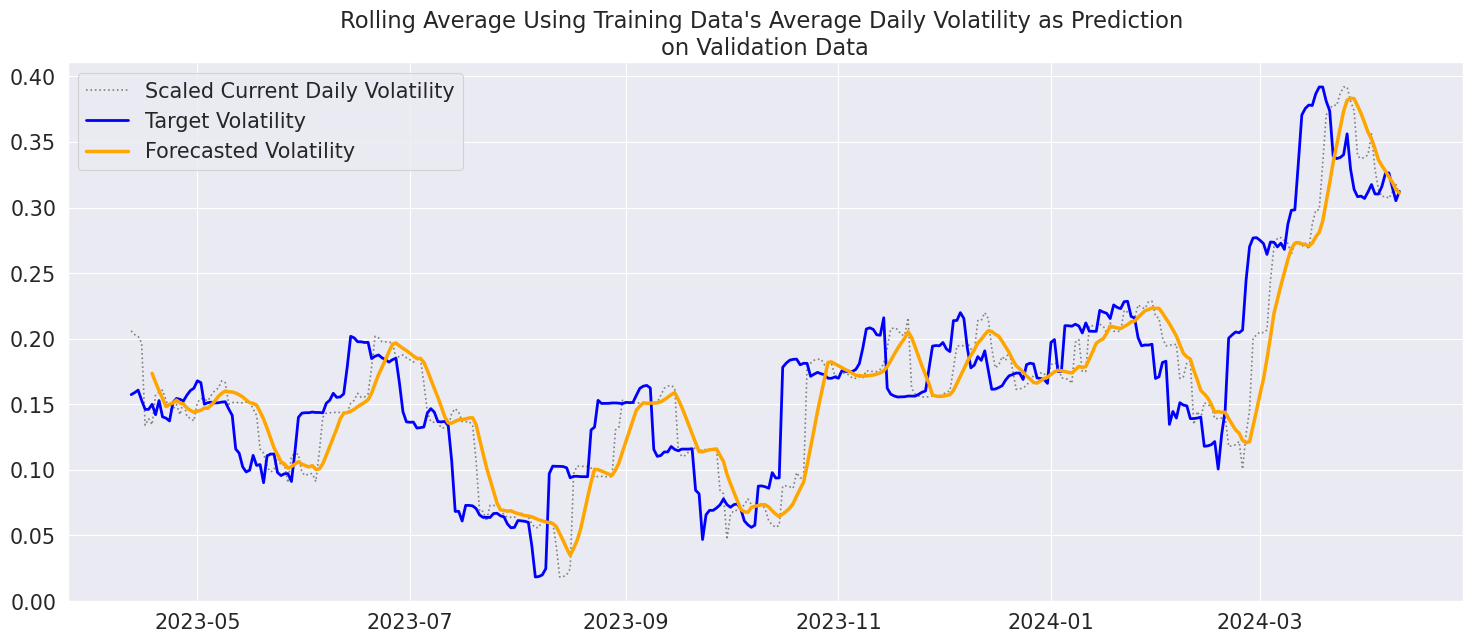

In [ ]:
rolling_pred = x_val_scaled.rolling(window=7, center=False).mean().values
rolling_pred = pd.Series(rolling_pred, index=lr_val.dropna().index)
viz_model(y_val_scaled, rolling_pred,
          "Rolling Average Using Training Data's Average Daily Volatility as Prediction")
plt.show();

In [ ]:
RMSPE(y_val_scaled[6:], rolling_pred[6:])

0.3801809471983218

In [ ]:
log_perf(y_val_scaled[6:], rolling_pred[6:], '7-day Rolling Average Forecast')

Model  Validation RMSPE  Validation RMSE
0  7-day Rolling Average Forecast          0.380181         0.043498

# **Model #2: Random Walk Naive Forecast**

A commonly known fact about volatility is that it tends to be **autocorrelated**, and **clusters** in the short-term. This property can be used to implement a naive model that just "predicts" future volatility by using whatever the daily volatility was at the immediate previous time step.

In this case, I'll use the average daily volatility of the most recent `INTERVAL_WINDOW` as predictions for the next 7 days, which is essentially using `vol_current` at time step `t` and prediction for `vol_future` at time step `t`.

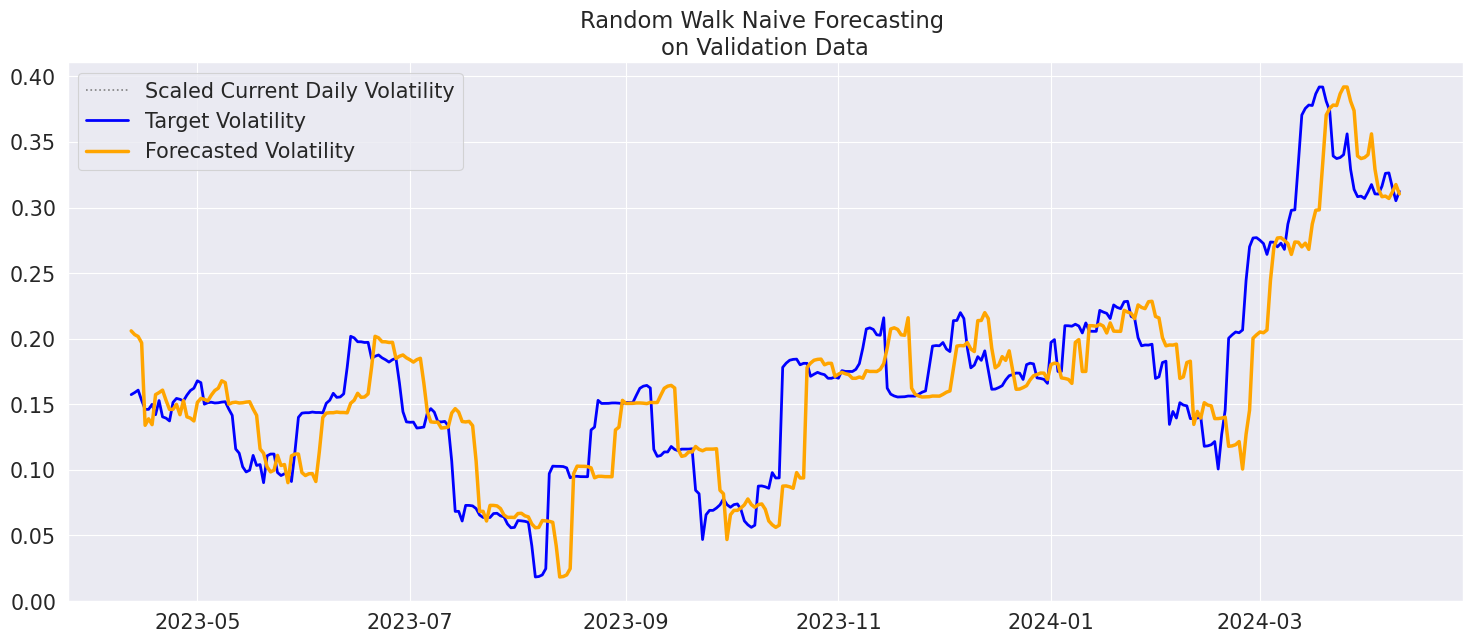

In [ ]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.show();

In [ ]:
log_perf(y_val_scaled, random_walk_preds,
         'Random Walk Naive Forecasting')

Model  Validation RMSPE  Validation RMSE
0  7-day Rolling Average Forecast          0.380181         0.043498
1   Random Walk Naive Forecasting          0.344205         0.037795

# **Model #3: Time-series Model: GARCH**

## **GARCH Model and Function Design**

In [ ]:
!pip install arch
from arch import arch_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 9.5 MB/s eta 0:00:00


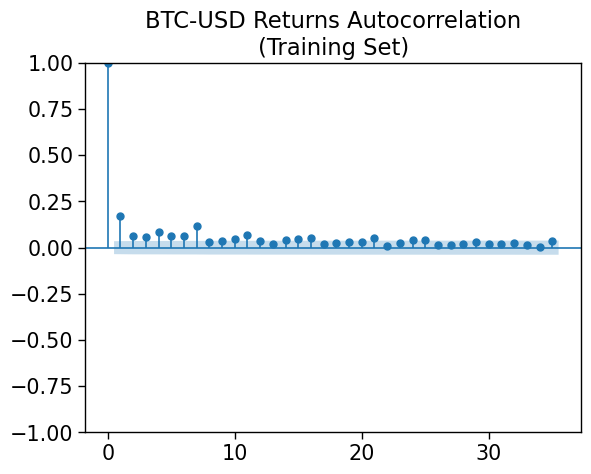

In [ ]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2,
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

The autocorrelation plots seem to indicate that there's only significant correlation up to the 7th lags, and the ones following don't seem to be too significant.

GARCH models are trained on percent returns. (One of the reasons I decided to normalize the volatilities across the board is because I am still not 100% sure which timescale GARCH conditional volatility is calculated in (likely daily), and still haven't figured out why the outputs here seem to be on a totally different scale compared to the volatilities previously calculated. Once I scale them, they match up much more nicely).

In [ ]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [ ]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2, alpha=0.7,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2, alpha=0.7,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

## **#1. Normal Dist. GARCH (1,1)**

In [ ]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8369.87
Distribution:                  Normal   AIC:                           16747.7
Method:            Maximum Likelihood   BIC:                           16771.9
                                        No. Observations:                 3128
Date:                Fri, May 10 2024   Df Residuals:                     3127
Time:                        15:04:47   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2073  5.581e-02      3.713  2.045e-04 [9.786e-

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

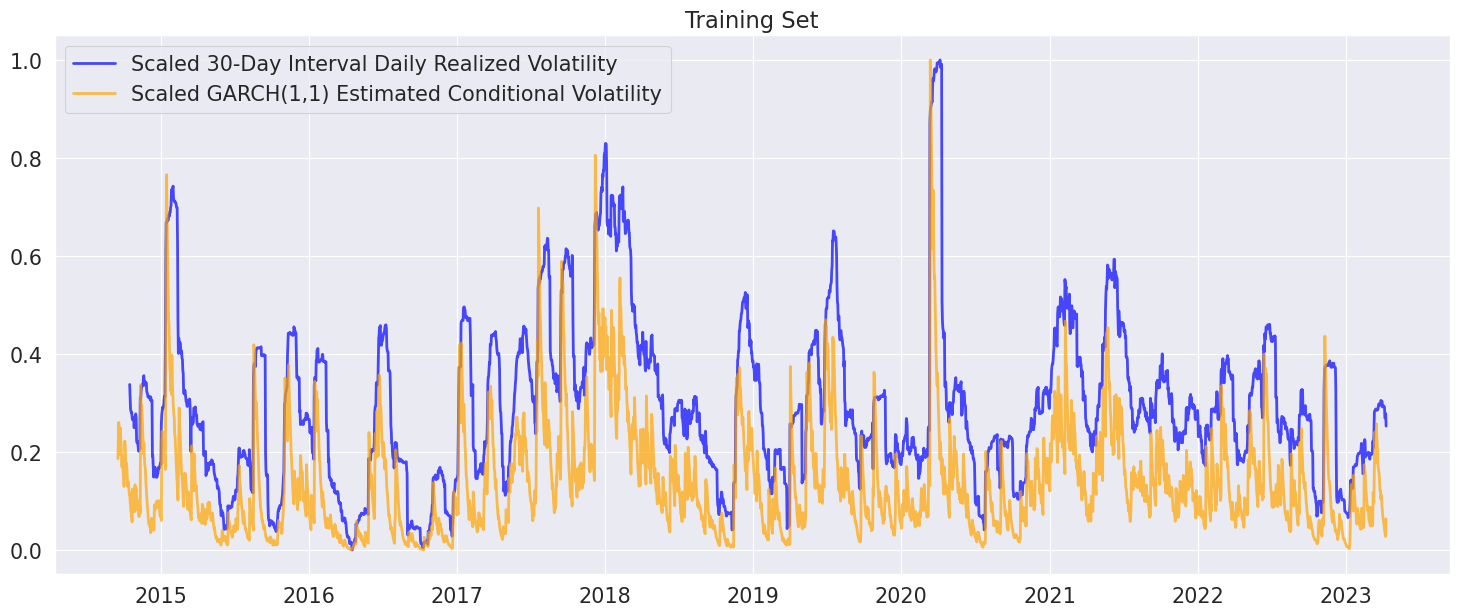

In [ ]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

### **Analytical-based Forecasting**
We will implement a rolling one-step forecasting here by refitting the model to ALL the datapoints available up to a certain time step before generating prediction for the next `n_future` days. For example, to make prediction on `vol_future` at time step `t`, we would fit the model to all the `returns` available up to time step `t` and then obtain the average forecasted volatility for a horizon of `n_future = 7`.

The volatility forecasts from the GARCH models using percent returns as input are on a totally different scale compared to the volatilities calculated from log returns. Therefore we are going to normalize the forecasted volatility based on the model's `conditional_volatility` output from the training data, and only comparing the scaled versions of volatilities on the Validation set.

To generate predictions for the validation set, we will use one-step walk-forward forecasting, meaning for each time step we will retrain model using all the available datapoints that time step and then predict the following 7 days' volatilities.

In [ ]:
# ROLLING FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

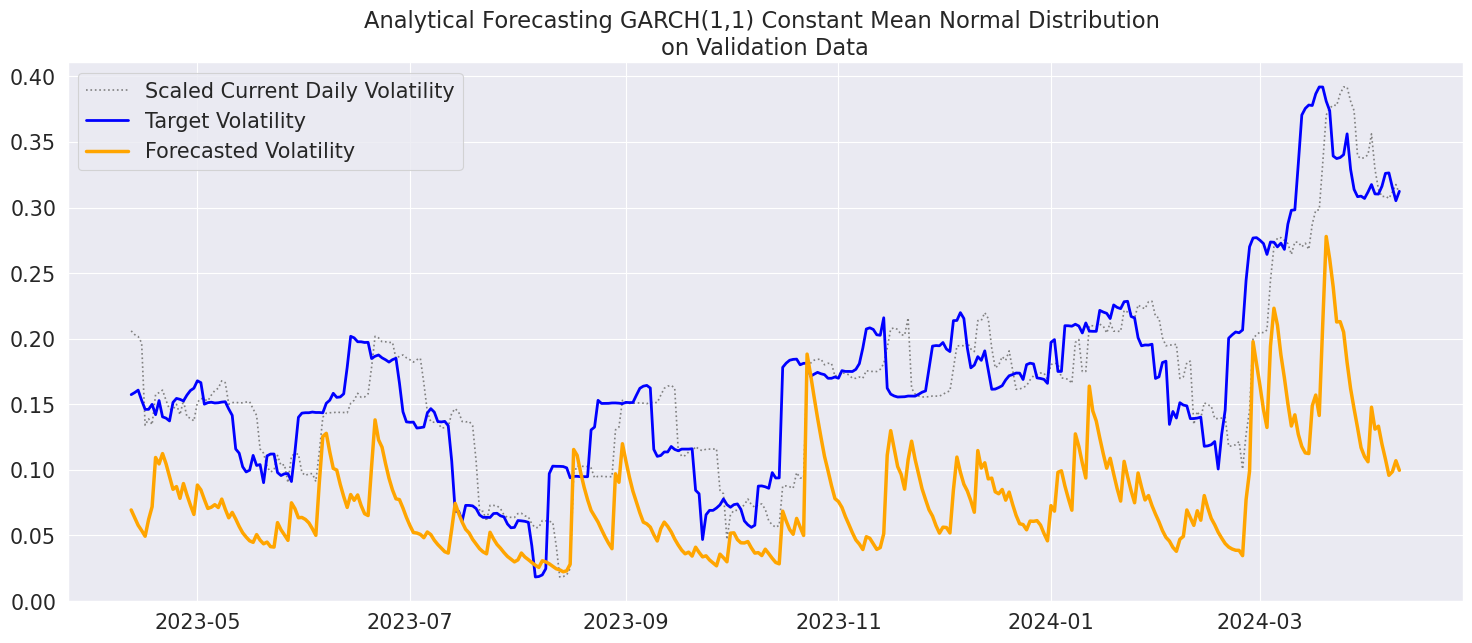

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled,
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled,
         'GARCH(1,1), Constant Mean, Normal Dist')

Model  Validation RMSPE  Validation RMSE
0          7-day Rolling Average Forecast          0.380181         0.043498
1           Random Walk Naive Forecasting          0.344205         0.037795
2  GARCH(1,1), Constant Mean, Normal Dist          0.542890         0.101500

## **#2. Student's T Dist. GARCH (1,1)**

In [ ]:
gm_2 = arch_model(r_train, vol='GARCH', dist='StudentsT', p=1, q=1)
result_2 = gm_2.fit(disp='off')
print()
print(result_2.summary())


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -7962.57
Distribution:      Standardized Student's t   AIC:                           15935.1
Method:                  Maximum Likelihood   BIC:                           15965.4
                                              No. Observations:                 3128
Date:                      Fri, May 10 2024   Df Residuals:                     3127
Time:                              15:05:02   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu       

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch_std, scaled_cond_vol_std = scale_tf_cond_vol(result_2)

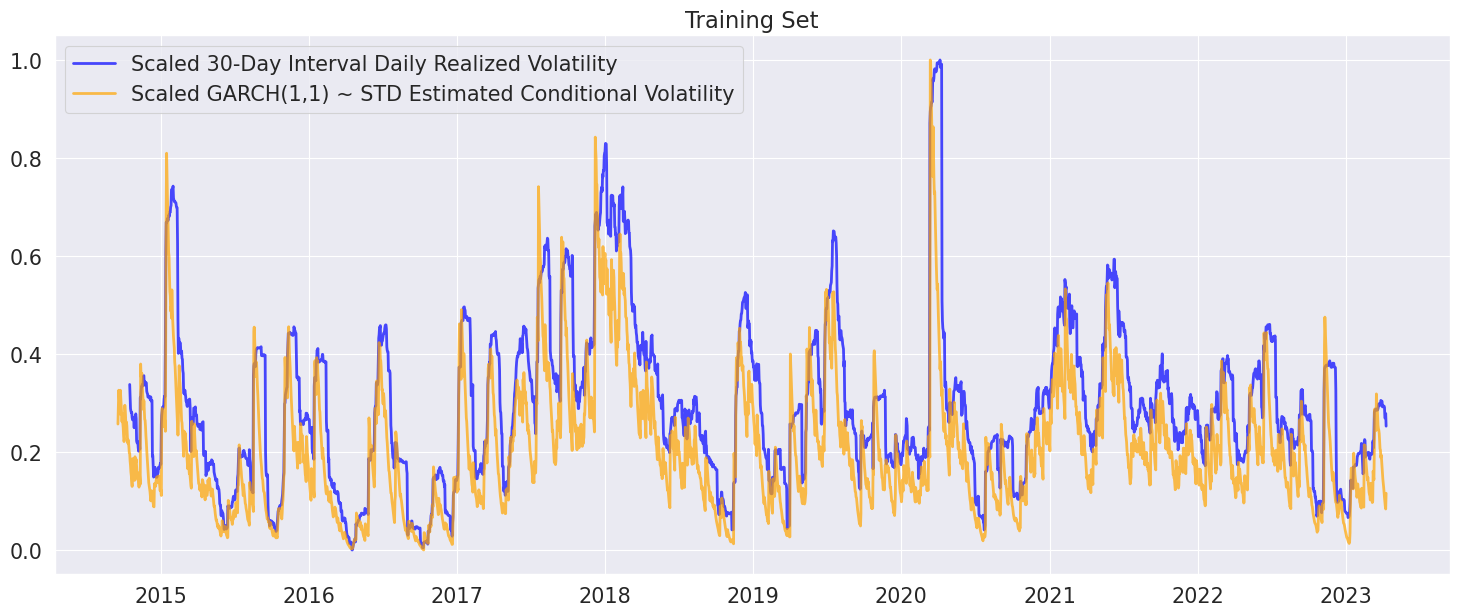

In [ ]:
viz_cond_vol(scaled_cond_vol_std, 'GARCH(1,1) ~ STD')

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1,
                       vol='GARCH', dist='StudentsT')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_2_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_2_preds = pd.Series(rolling_forecasts, index=val_idx)
gm_2_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_2_preds)

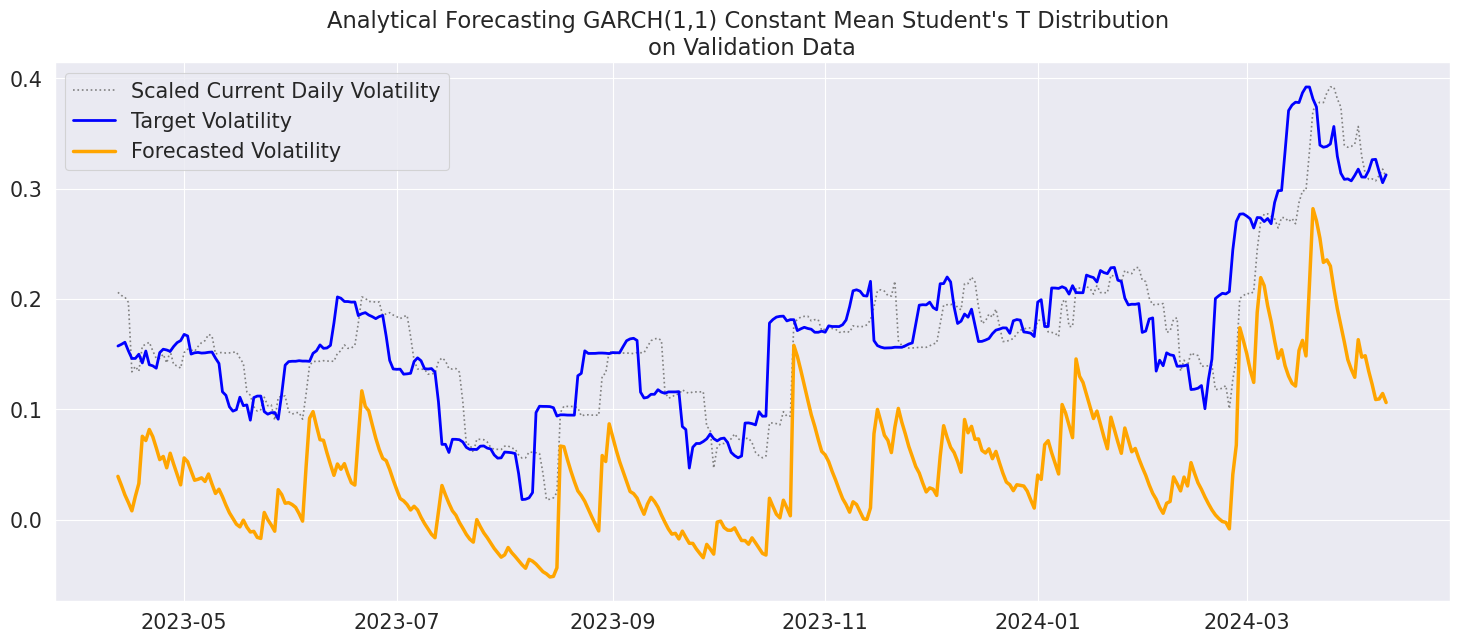

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_2_preds_scaled,
          'Analytical Forecasting GARCH(1,1) Constant Mean Student\'s T Distribution')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_2_preds_scaled,
         "GARCH(1,1), Constant Mean, Students' T Distribution")

Model  Validation RMSPE  \
0                     7-day Rolling Average Forecast          0.380181   
1                      Random Walk Naive Forecasting          0.344205   
2             GARCH(1,1), Constant Mean, Normal Dist          0.542890   
3  GARCH(1,1), Constant Mean, Students' T Distrib...          0.899733   

   Validation RMSE  
0         0.043498  
1         0.037795  
2         0.101500  
3         0.125962

## **#3. Skewed Student's T Dist. GARCH (1,1)**

In [ ]:
gm_3 = arch_model(r_train, vol='GARCH', dist='skewt', p=1, q=1)
result_3 = gm_3.fit(disp='off')
print()
print(result_3.summary())


                           Constant Mean - GARCH Model Results                           
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -7962.39
Distribution:      Standardized Skew Student's t   AIC:                           15936.8
Method:                       Maximum Likelihood   BIC:                           15973.1
                                                   No. Observations:                 3128
Date:                           Fri, May 10 2024   Df Residuals:                     3127
Time:                                   15:05:27   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch_sstd, scaled_cond_vol_sstd = scale_tf_cond_vol(result_3)

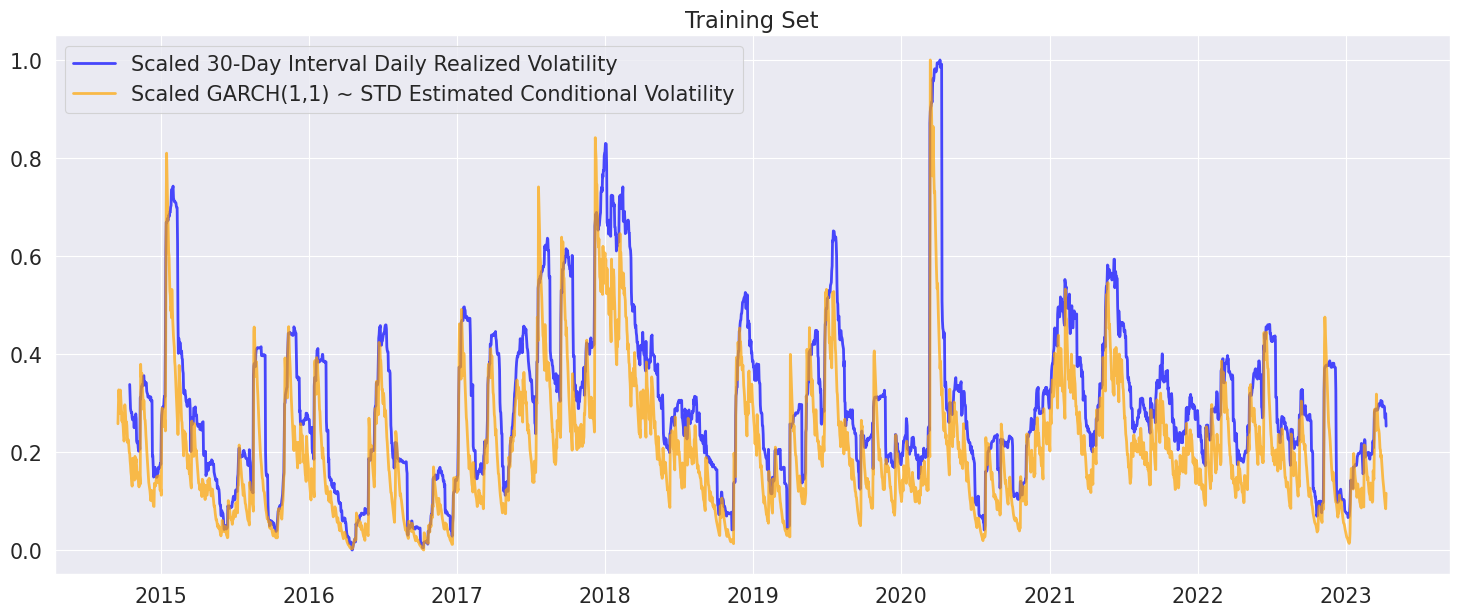

In [ ]:
viz_cond_vol(scaled_cond_vol_sstd, 'GARCH(1,1) ~ STD')

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1,
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_3_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_3_preds = pd.Series(rolling_forecasts, index=val_idx)
gm_3_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_3_preds)

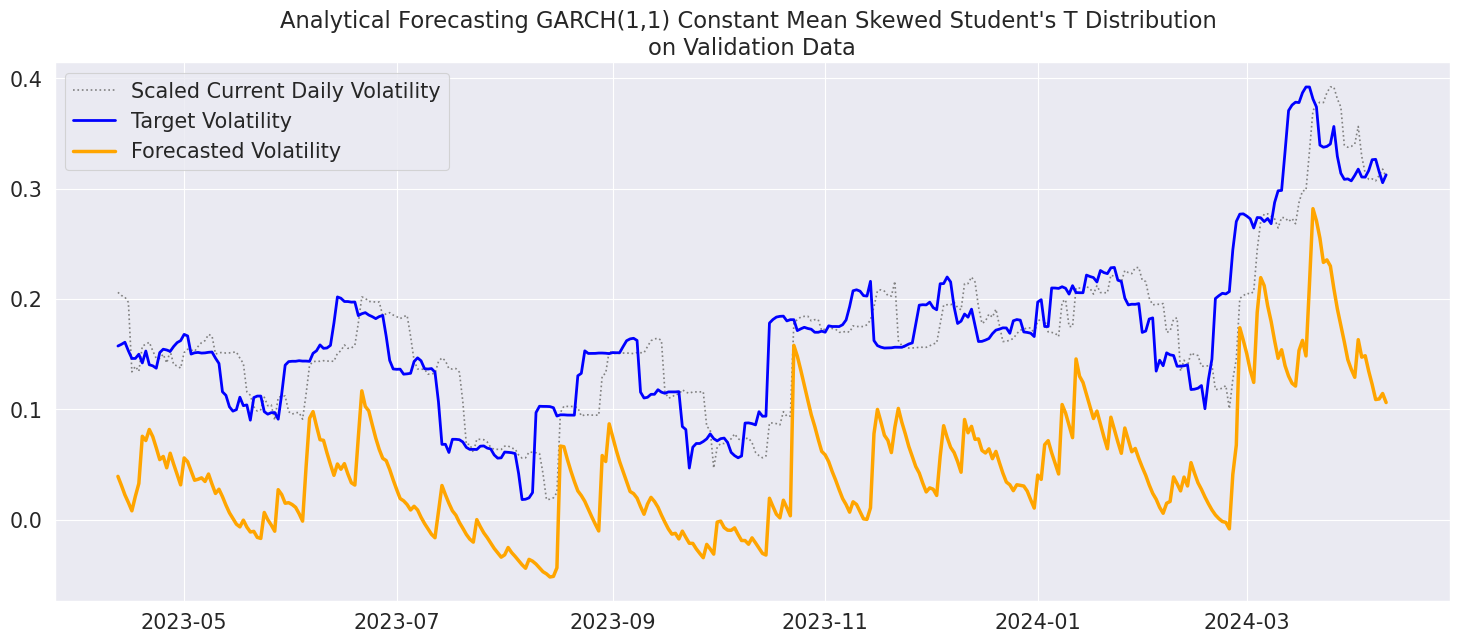

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_2_preds_scaled,
          'Analytical Forecasting GARCH(1,1) Constant Mean Skewed Student\'s T Distribution')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_3_preds_scaled,
         "GARCH(1,1), Constant Mean, Skewed Students' T Distribution")

Model  Validation RMSPE  \
0                     7-day Rolling Average Forecast          0.380181   
1                      Random Walk Naive Forecasting          0.344205   
2             GARCH(1,1), Constant Mean, Normal Dist          0.542890   
3  GARCH(1,1), Constant Mean, Students' T Distrib...          0.899733   
4  GARCH(1,1), Constant Mean, Skewed Students' T ...          0.901331   

   Validation RMSE  
0         0.043498  
1         0.037795  
2         0.101500  
3         0.125962  
4         0.126259

## **#4. Skewed Student's T Dist. GJR-GARCH (1,1)**




(Reference: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html#Specifying-Common-Models)

There's another member in the GARCH family called **TARCH**, which is short for **Threshold Autoregressive Conditional Heteroskedasticity** (and also known as **ZARCH**). TARCH models the volatility using absolute values (instead of squares). This model is specified using `power=1.0` since the default power, `2.0`, corresponds to variance processes that evolve in squares. In addition, asymmetric impact is also incorporated into the GARCH framework by using a dummy variable

The volatility process in a TARCH(1,1) model is given by:

\begin{align*}
\sigma_{t} = \omega + \alpha|\epsilon_{t-1}| + \gamma|\epsilon_{t-1}|I_{[\epsilon_{t-1}<0]} + \beta\sigma_{t-1}
\end{align*}

The basic GARCH model assumes positive and negative news have similar impact on volatility. However, in reality the market tends to "*take the stairs up and the elevator down*". In other words, the impact is usually asymmetric, and negative impacts tends to affect the volatility more than positive ones.

There's another member in the GARCH family that accounts for assymmetry of shocks reponses called **GJR-GARCH** (short for **Glosten-Jagannathan-Runkle GARCH**).

Additional inputs can be used to construct other models. In this case, by setting `o` to 1, which means the model would include one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics.

In [ ]:
gjr_gm = arch_model(r_train, p=1, q=1, o=1,
                    vol='GARCH', dist='skewt')
result_4 = gjr_gm.fit(disp='off')
print(result_4.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -7961.68
Distribution:      Standardized Skew Student's t   AIC:                           15937.4
Method:                       Maximum Likelihood   BIC:                           15979.7
                                                   No. Observations:                 3128
Date:                           Fri, May 10 2024   Df Residuals:                     3127
Time:                                   15:06:02   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_4)

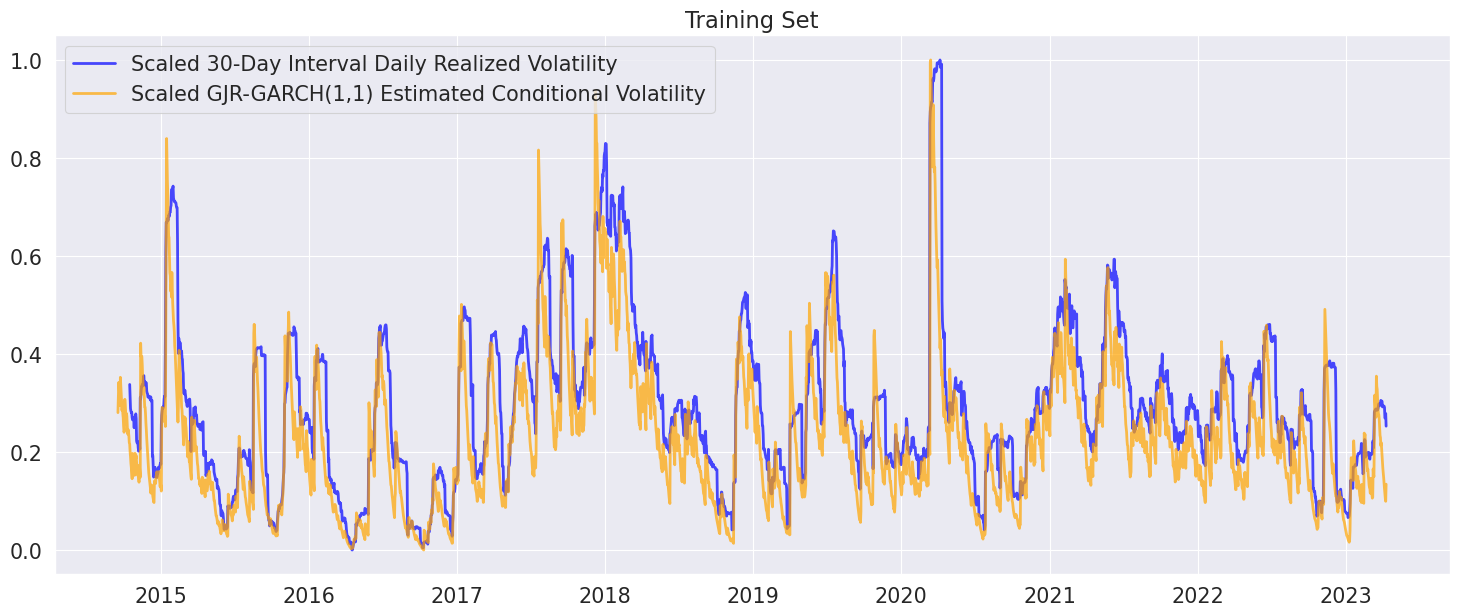

In [ ]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

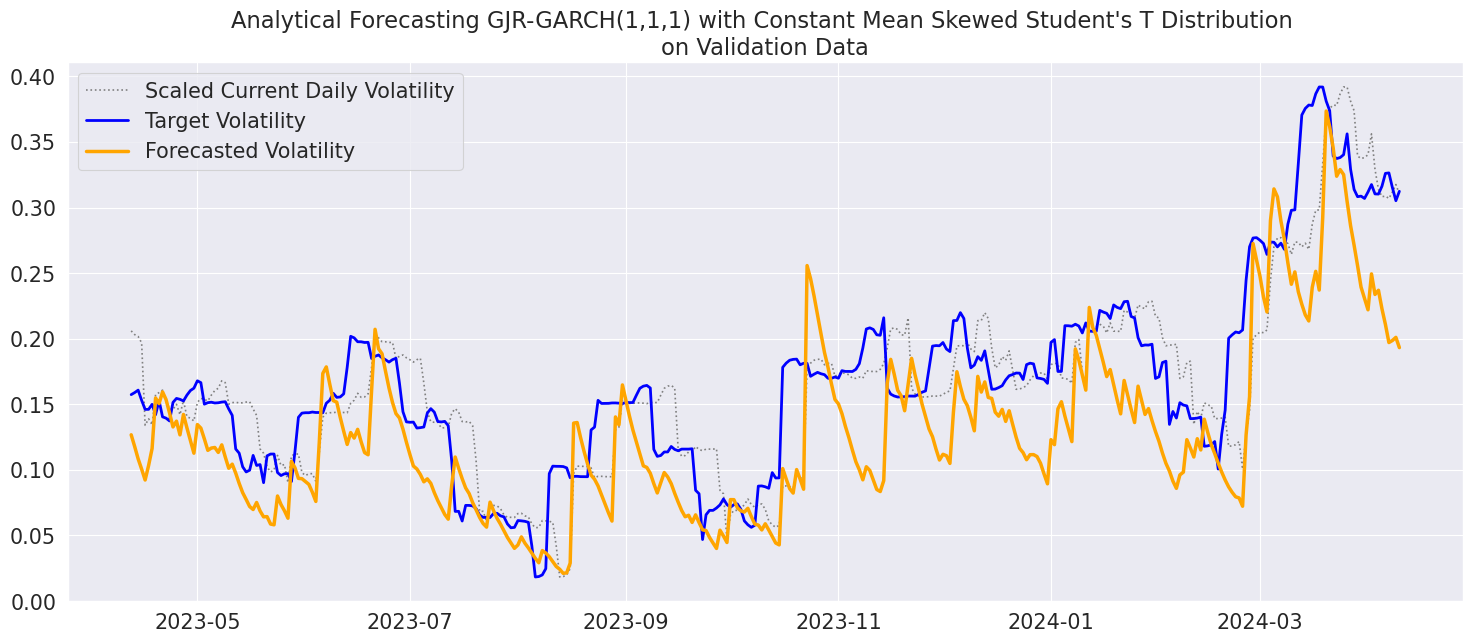

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_1_preds_scaled,
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled,
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewed Students' T Distribution")

Model  Validation RMSPE  \
0                     7-day Rolling Average Forecast          0.380181   
1                      Random Walk Naive Forecasting          0.344205   
2             GARCH(1,1), Constant Mean, Normal Dist          0.542890   
3  GARCH(1,1), Constant Mean, Students' T Distrib...          0.899733   
4  GARCH(1,1), Constant Mean, Skewed Students' T ...          0.901331   
5  Analytical GJR-GARCH(1,1,1), Constant Mean, Sk...          0.319793   

   Validation RMSE  
0         0.043498  
1         0.037795  
2         0.101500  
3         0.125962  
4         0.126259  
5         0.054998

## **#5. Skewed Student's T Dist. TARCH (1,1,1)**

In [ ]:
t_am = arch_model(r_train, p=1, q=1, o=1, power=1.0,
                  dist='skewt')
result_5 = t_am.fit(disp='off')
print(result_5.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -7958.29
Distribution:      Standardized Skew Student's t   AIC:                           15930.6
Method:                       Maximum Likelihood   BIC:                           15972.9
                                                   No. Observations:                 3128
Date:                           Fri, May 10 2024   Df Residuals:                     3127
Time:                                   15:06:52   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_5)

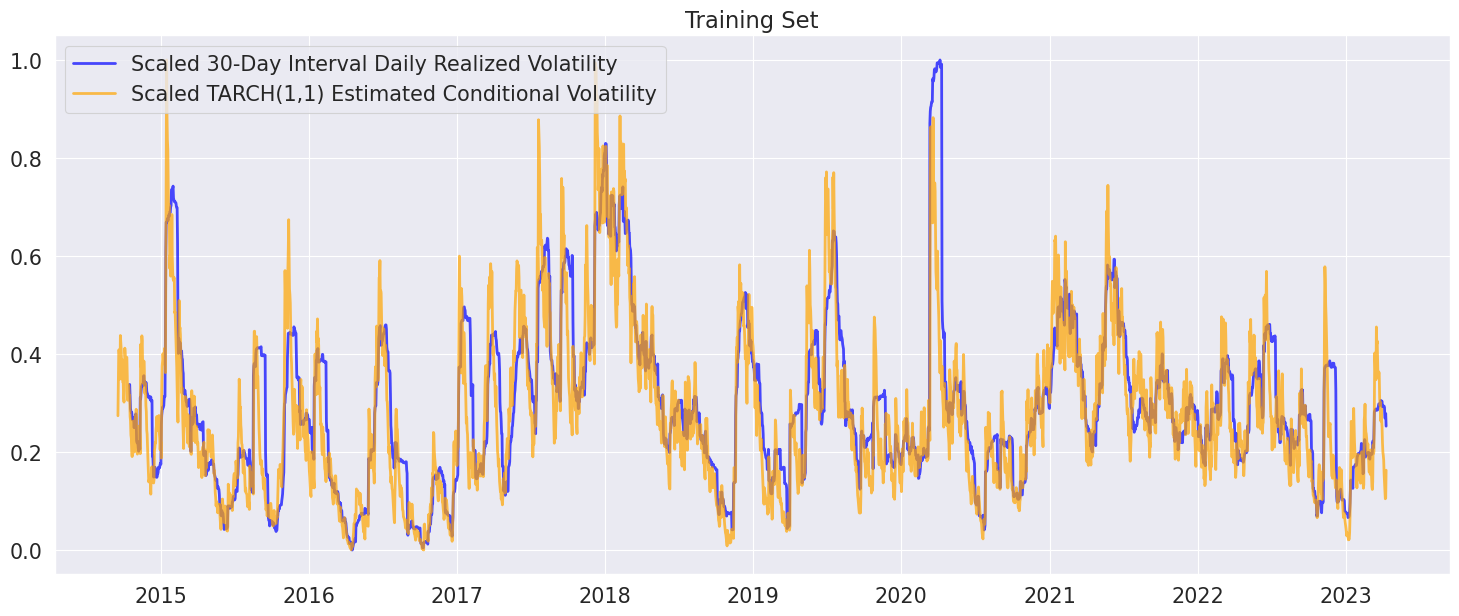

In [ ]:
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)

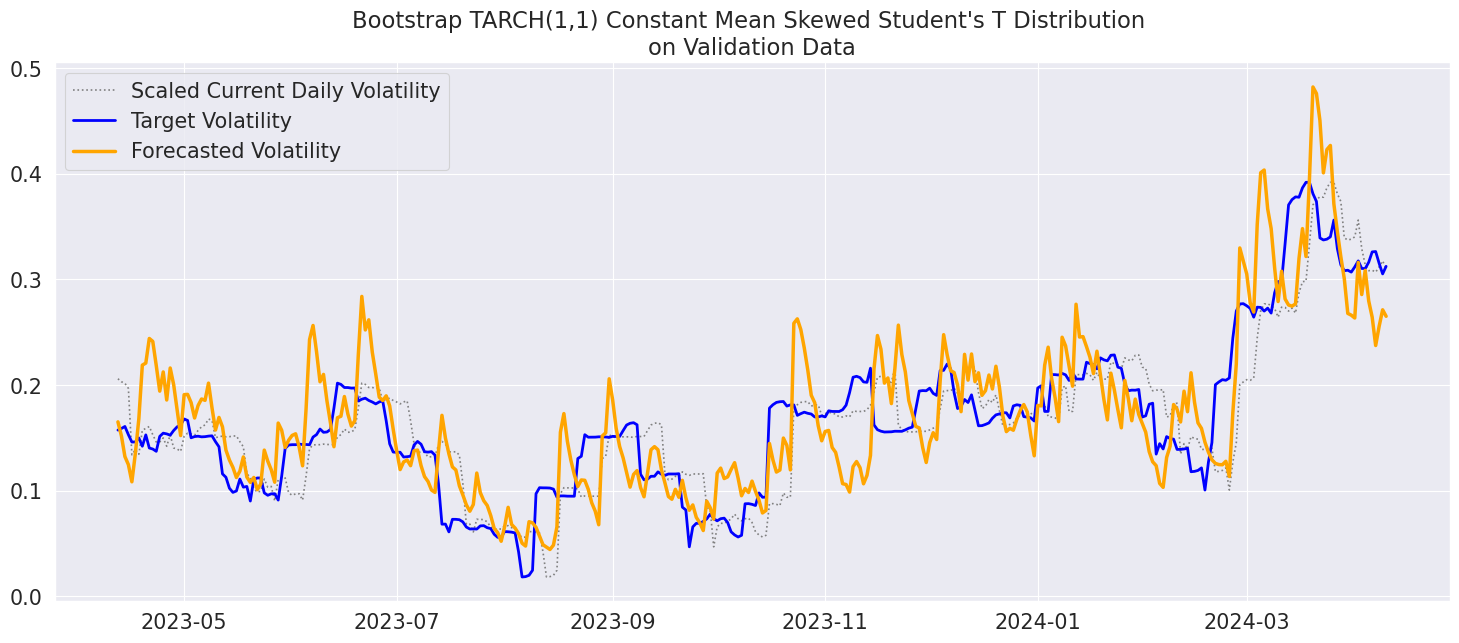

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_bs_preds_scaled,
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_bs_preds_scaled,
         "Analytical TARCH(1,1,1), Constant Mean, Skewed Students' T Distribution")

Model  Validation RMSPE  \
0                     7-day Rolling Average Forecast          0.380181   
1                      Random Walk Naive Forecasting          0.344205   
2             GARCH(1,1), Constant Mean, Normal Dist          0.542890   
3  GARCH(1,1), Constant Mean, Students' T Distrib...          0.899733   
4  GARCH(1,1), Constant Mean, Skewed Students' T ...          0.901331   
5  Analytical GJR-GARCH(1,1,1), Constant Mean, Sk...          0.319793   
6  Analytical TARCH(1,1,1), Constant Mean, Skewed...          0.383757   

   Validation RMSE  
0         0.043498  
1         0.037795  
2         0.101500  
3         0.125962  
4         0.126259  
5         0.054998  
6         0.046129

## **#6. Skewed Student's T Dist. TARCH (2,1,2) - thru Optimization**

### TARCH Optimization
We'll create a range of values for p, q and o from 0 to 3 (inclusive), and then record each's model's performance on unseen data using RMSPE. Since `p` cannot take a value of `0`, we'll eliminate that from the list of permutations.

*Running this section of code is really time-consuming (about 20 mins!) We've already run once and known its final answer ((2,1,2) is the best), so we choose to comment out this section.*

In [ ]:
# import itertools
# pqo_s = [p for p in itertools.product(range(3), repeat=3)]
# # ELIMINATE PERMUTATIONS WITH p = 0
# pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
# # RMSPE ON VALIDATION SET
# rmspe_s = []
# # LOG LIKELIHOOD
# LLH_s = []
# # BIC
# bic_s = []

# for p, q, o in pqo_s:

#     # FITTING TARCH(p,q,o) MODEL
#     t_gm_pqo = arch_model(r_train, p=p, q=q, o=o, power=1.0,
#                           dist='skewt')
#     t_gm_pqo_fit = t_gm_pqo.fit(disp='off')

#     # SCALING CONDITIONAL VOLATILITY OUTPUTS
#     sclr = MinMaxScaler()
#     cond_vol_arr = t_gm_pqo_fit.conditional_volatility.values.reshape(-1,1)

#     # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
#     sclr = sclr.fit(cond_vol_arr)

#     # INITIALIZING rolling_forecasts VALUES LIST
#     rolling_forecasts = []

#     # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
#     for i in range(len(r_val)):
#         # GET THE DATA AT ALL PREVIOUS TIME STEPS
#         idx = val_idx[i]
#         train = df.returns[:idx].dropna()

#         # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
#         model = arch_model(train, p=p, q=q, o=o, power=1.0,
#                           dist='skewt')
#         model_fit = model.fit(disp='off')

#         # MAKE PREDICTION
#         vaR = model_fit.forecast(horizon=n_future,
#                                  reindex=False,
#                                  method='bootstrap').variance.values
#         pred = np.sqrt(np.mean(vaR))

#         # APPEND TO rolling_forecasts LIST
#         rolling_forecasts.append(pred)

#     # CONVERT PREDICTIONS
#     y_preds = pd.Series(rolling_forecasts, index=val_idx)

#     # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
#     y_preds_scaled = transform_volatility_to_scaler(sclr, y_preds)

#     # APPENDING PERFORMANCE METRICS TO LISTS
#     LLH_s.append(t_gm_pqo_fit.loglikelihood)
#     bic_s.append(t_gm_pqo_fit.bic)
#     rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))

In [ ]:
# # GET THE VALUES OF p/q/o THAT YIELDS LOWEST VALIDATION RMSPE
# print(f'Lowest RMSPE is {np.min(rmspe_s)} using TARCH{pqo_s[np.argmin(rmspe_s)]}')

In [ ]:
# best_pqo = pqo_s[np.argmin(rmspe_s)]

In [ ]:
# with sns.axes_style("darkgrid"):
#     fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
#     xlabels = [str(v) for v in pqo_s]

#     ax1.plot(xlabels, LLH_s)
#     ax1.set_xticklabels(xlabels, rotation=90)
#     ax1.vlines(x=str(best_pqo),
#                ls='--', color='orange',
#                ymin=np.min(LLH_s), ymax=np.max(LLH_s))
#     ax1.set_ylabel('Log-Likelihood')

#     ax2.plot(xlabels, bic_s)
#     ax2.set_xticklabels(xlabels, rotation=90)
#     ax2.vlines(x=str(best_pqo),
#                ls='--', color='orange',
#                ymin=np.min(bic_s), ymax=np.max(bic_s))
#     ax2.set_ylabel('BIC')

#     ax3.plot(xlabels, rmspe_s)
#     ax3.set_xticklabels(xlabels, rotation=90)
#     ax3.vlines(x=str(best_pqo),
#                ls='--', color='orange',
#                ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))
#     ax3.set_ylabel('Validation RMSPE')

#     ax1.set_title('Performance Metrics of TARCH Models Using Various p/q/o Values')
#     plt.tight_layout()
#     plt.show();

###**TARCH Optimization Conclusion**
Lowest RMSPE is 0.3640264632480912 using TARCH(2, 1, 2)

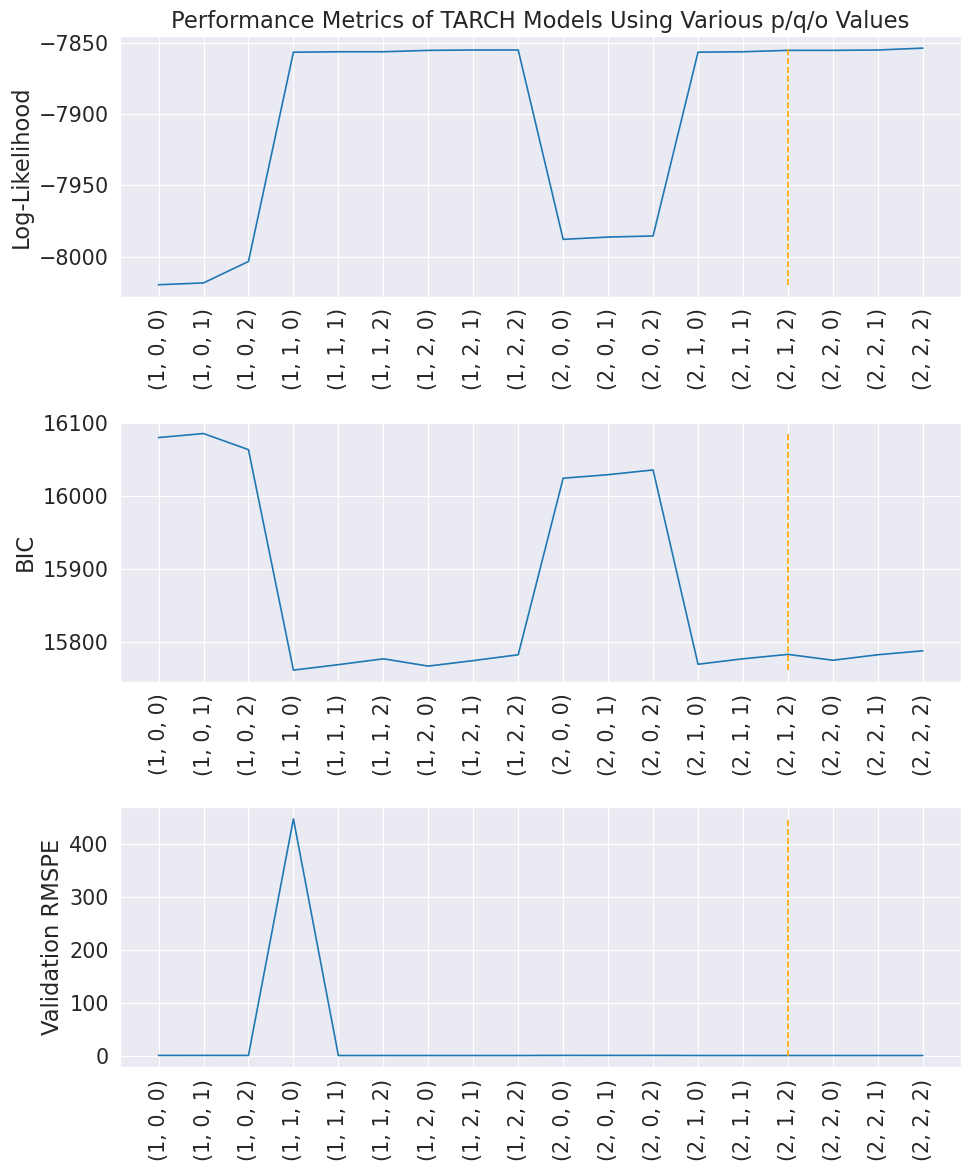

In [ ]:
t_120 = arch_model(r_train, p=2, q=1, o=2, power=1.0,
                  dist='skewt')
result_6 = t_120.fit(disp='off')
print(result_6.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -7957.60
Distribution:      Standardized Skew Student's t   AIC:                           15933.2
Method:                       Maximum Likelihood   BIC:                           15987.6
                                                   No. Observations:                 3128
Date:                           Fri, May 10 2024   Df Residuals:                     3127
Time:                                   15:07:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch_212, scaled_tarch_212_cond_vol = scale_tf_cond_vol(result_6)

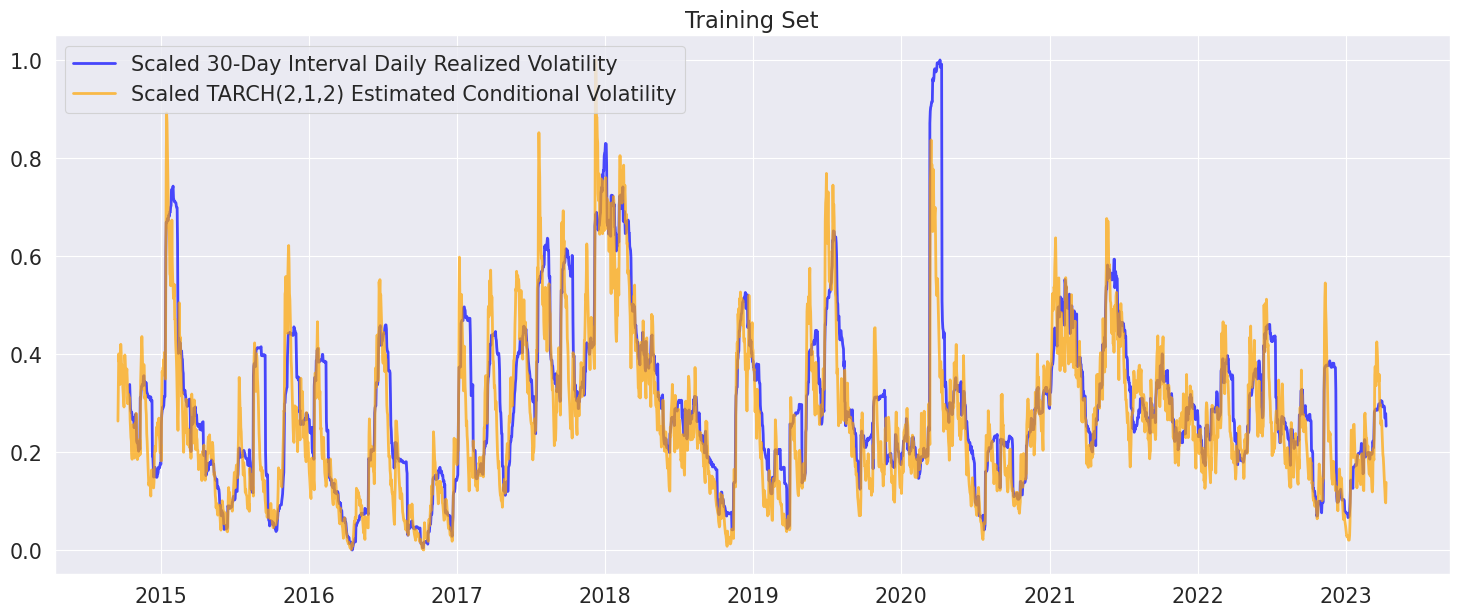

In [ ]:
viz_cond_vol(scaled_tarch_212_cond_vol, 'TARCH(2,1,2)')

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=2, q=1, o=2, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_212_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_212_preds_scaled = transform_volatility_to_scaler(scaler_tarch_212, t_bs_212_preds)

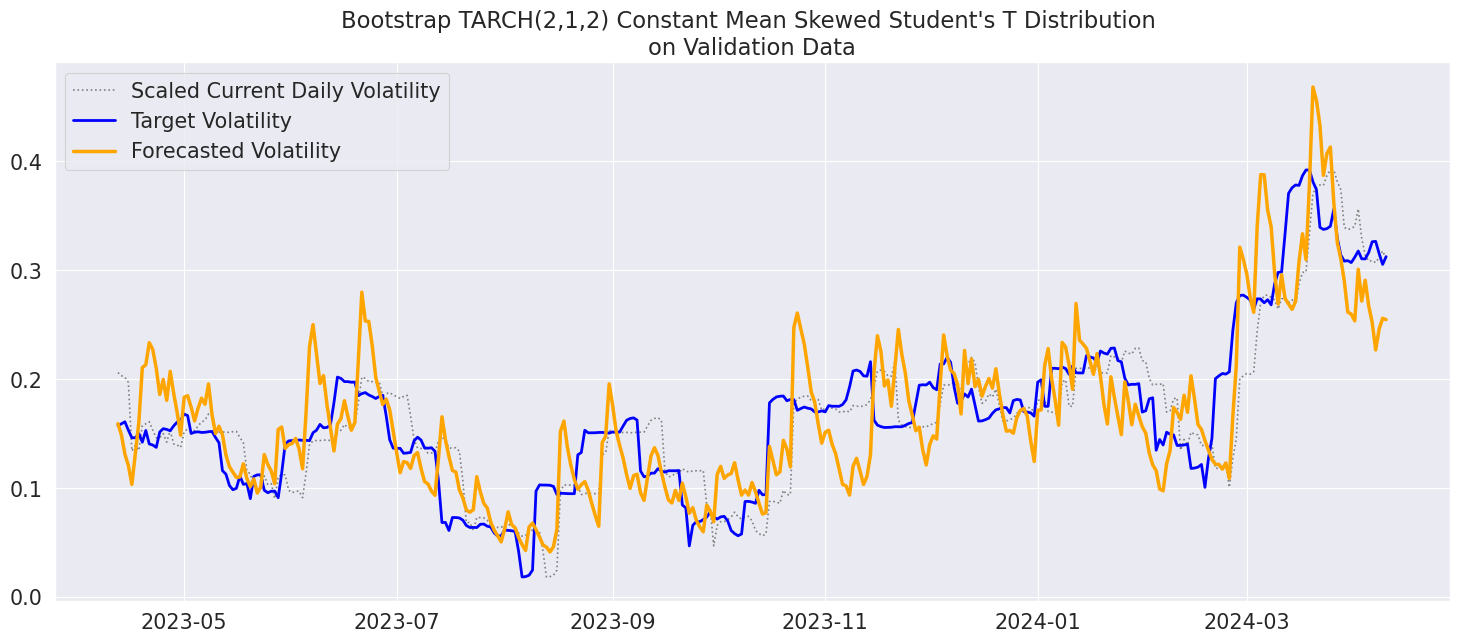

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_212_preds_scaled,
          "Bootstrap TARCH(2,1,2) Constant Mean Skewed Student's T Distribution")

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_212_preds_scaled,
         "Bootstrap TARCH(2,1,2), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                     7-day Rolling Average Forecast          0.380181   
1                      Random Walk Naive Forecasting          0.344205   
2             GARCH(1,1), Constant Mean, Normal Dist          0.542890   
3  GARCH(1,1), Constant Mean, Students' T Distrib...          0.899733   
4  GARCH(1,1), Constant Mean, Skewed Students' T ...          0.901331   
5  Analytical GJR-GARCH(1,1,1), Constant Mean, Sk...          0.319793   
6  Analytical TARCH(1,1,1), Constant Mean, Skewed...          0.383757   
7  Bootstrap TARCH(2,1,2), Constant Mean, Skewt Dist          0.356071   

   Validation RMSE  
0         0.043498  
1         0.037795  
2         0.101500  
3         0.125962  
4         0.126259  
5         0.054998  
6         0.046129  
7         0.044917

# **Final Volatitlity Forecast**

By comparing the metrics and graphic characteristics, the TGARCH(2,1,2) gives the best estimation result.
So next, we will use the model to test the most recent 30 days data and forecast future 7 day's volatiltiy

In [ ]:
y_scaled = transform_volatility_to_scaler(scaler_vol, df.vol_future)
x_scaled = transform_volatility_to_scaler(scaler_vol, df.vol_current)

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch_212, scaled_tarch_212_cond_vol = scale_tf_cond_vol(result_6)

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(test_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = test_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=2, q=1, o=2, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))


    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

preds_final = pd.DataFrame(rolling_forecasts, index=test_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
preds_final_scaled = transform_volatility_to_scaler(scaler_tarch_212, preds_final)

In [ ]:
split_date_1 = datetime.today() - timedelta(days=1)
forecasts_7d = model_fit.forecast(horizon=n_future,
                               start=split_date_1,
                               reindex=False,
                               method='bootstrap')
forecasts_7d.variance[split_date_1:]
forecasts_7d = np.sqrt(forecasts_7d.variance[split_date_1:])
forecasts_7d = forecasts_7d.transpose()
forecasts_7d

# Create a list of future dates
future_dates = [split_date_1 + timedelta(days=i) for i in range(1, 8)]

# Convert the list of dates to a Pandas Series
future_dates_series = pd.Series(future_dates)

# Set the Series as the index of the dataframe
forecasts_7d.index = future_dates_series
forecasts_7d.index = forecasts_7d.index.strftime('%Y-%m-%d')
forecasts_7d.index = pd.to_datetime(forecasts_7d.index)

forecasts_7d.rename(columns={forecasts_7d.columns[0]: "Forecasted Volatility"}, inplace=True)
forecasts_7d_scaled = transform_volatility_to_scaler(scaler_tarch_212, forecasts_7d)

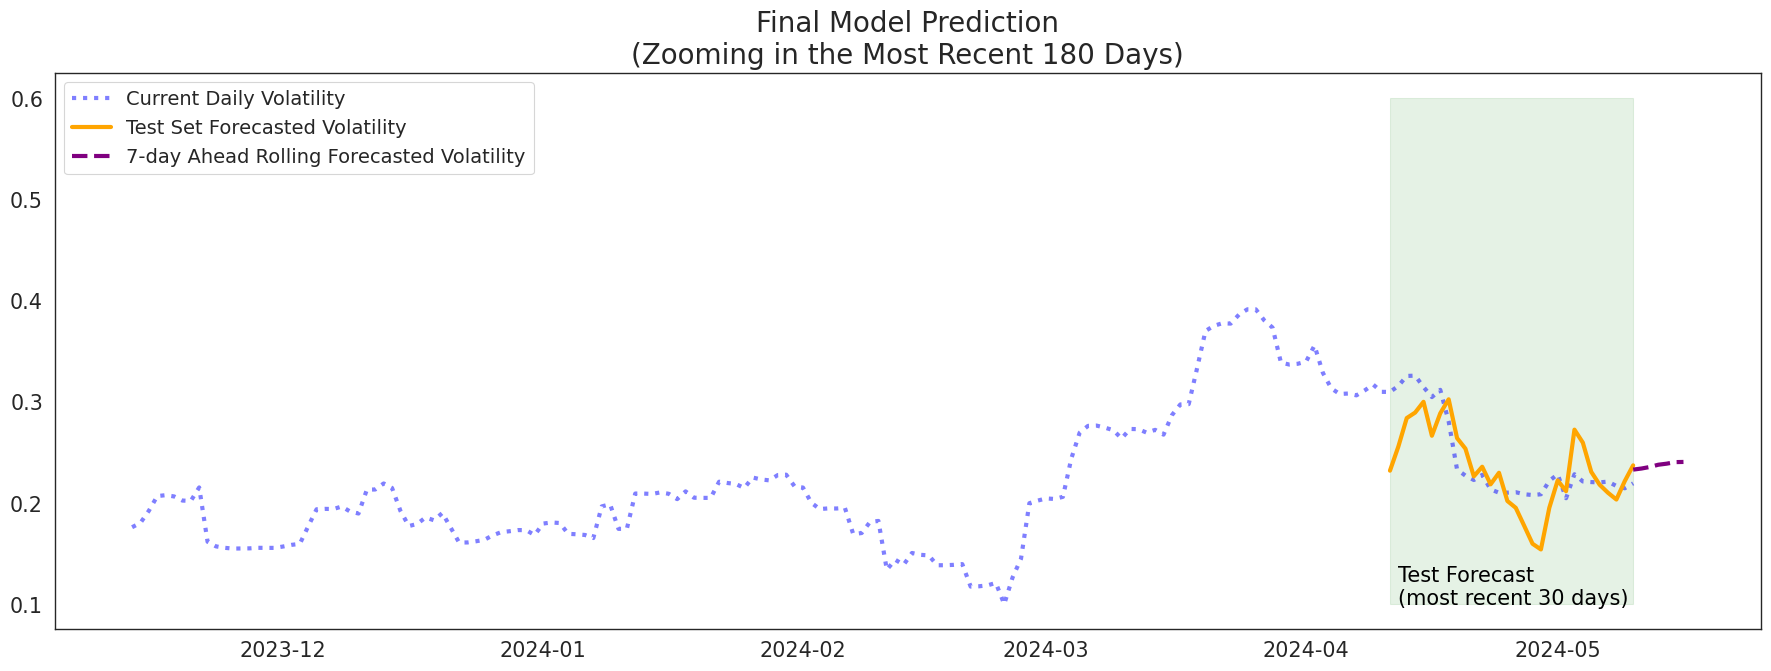

In [ ]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 180

    ax1.plot(x_scaled[-n_display:], color='blue',  ls=':', lw=3, alpha=0.5,
                label=f"Current Daily Volatility")
    ax1.plot(preds_final_scaled, color='orange', lw=3,
                label=f'Test Set Forecasted Volatility')
    ax1.plot(forecasts_7d_scaled, color='purple', lw=3, ls='--',
                label=f'7-day Ahead Rolling Forecasted Volatility')

    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA
    w = len(test_idx) - 1
    h = 0.5
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = y_scaled[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 1)], 0.1,
             'Test Forecast\n(most recent 30 days)',
             fontsize=15, color='black')

    plt.title(f'Final Model Prediction\n(Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.show();

In [ ]:
RMSPE(x_test_scaled, preds_final_scaled)

0.12224705836754803

#  **Application #1: Risk Management with Value at Risk** --- by Liru Gong & Xinpeng Tao

In [ ]:
from scipy.stats import norm

forecasts_7d_var = forecasts_7d.copy()
forecasts_7d_var['Forecasted Volatility'] = forecasts_7d['Forecasted Volatility'] /100

portfolio_value = 100  # Assume the portfolio value is 100, which could be used as a percentage measure
VaRs_95 = -portfolio_value * forecasts_7d_var['Forecasted Volatility'] * norm.ppf(0.05)
VaRs_99 = -portfolio_value * forecasts_7d_var['Forecasted Volatility'] * norm.ppf(0.01)

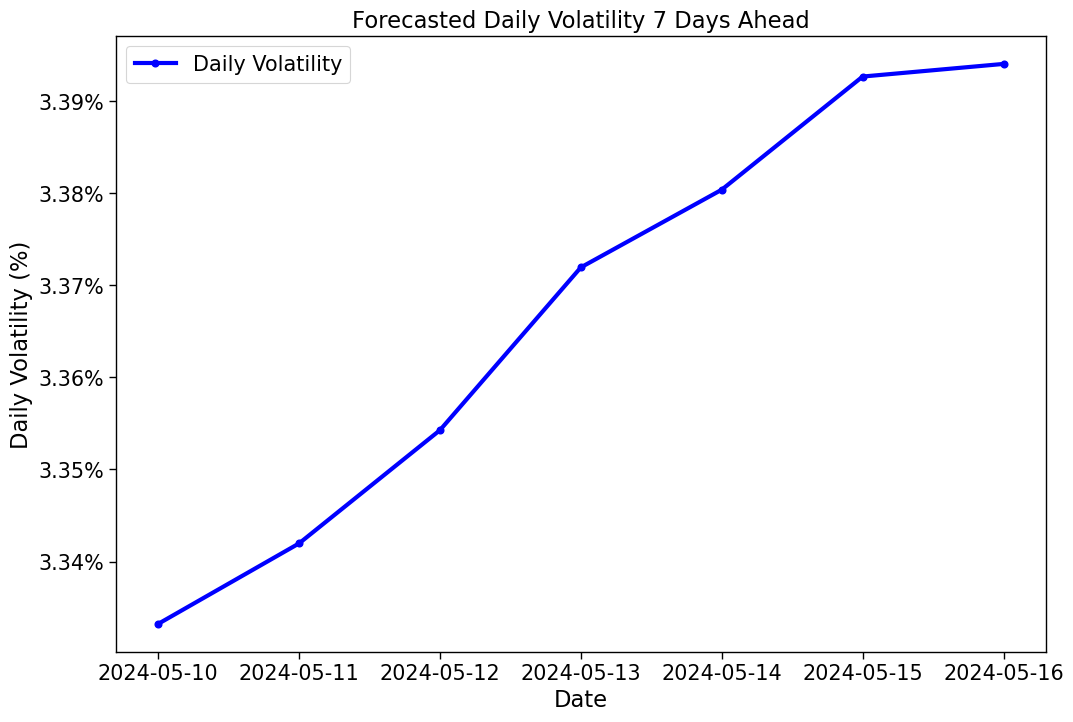

In [ ]:
import matplotlib.ticker as mtick
plt.figure(figsize=(12, 8))
plt.plot(forecasts_7d.index, forecasts_7d_var['Forecasted Volatility'], label='Daily Volatility', marker='o', color='blue', lw=3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=2))

plt.title('Forecasted Daily Volatility 7 Days Ahead')
plt.xlabel('Date')
plt.ylabel('Daily Volatility (%)')
plt.legend()
plt.show()

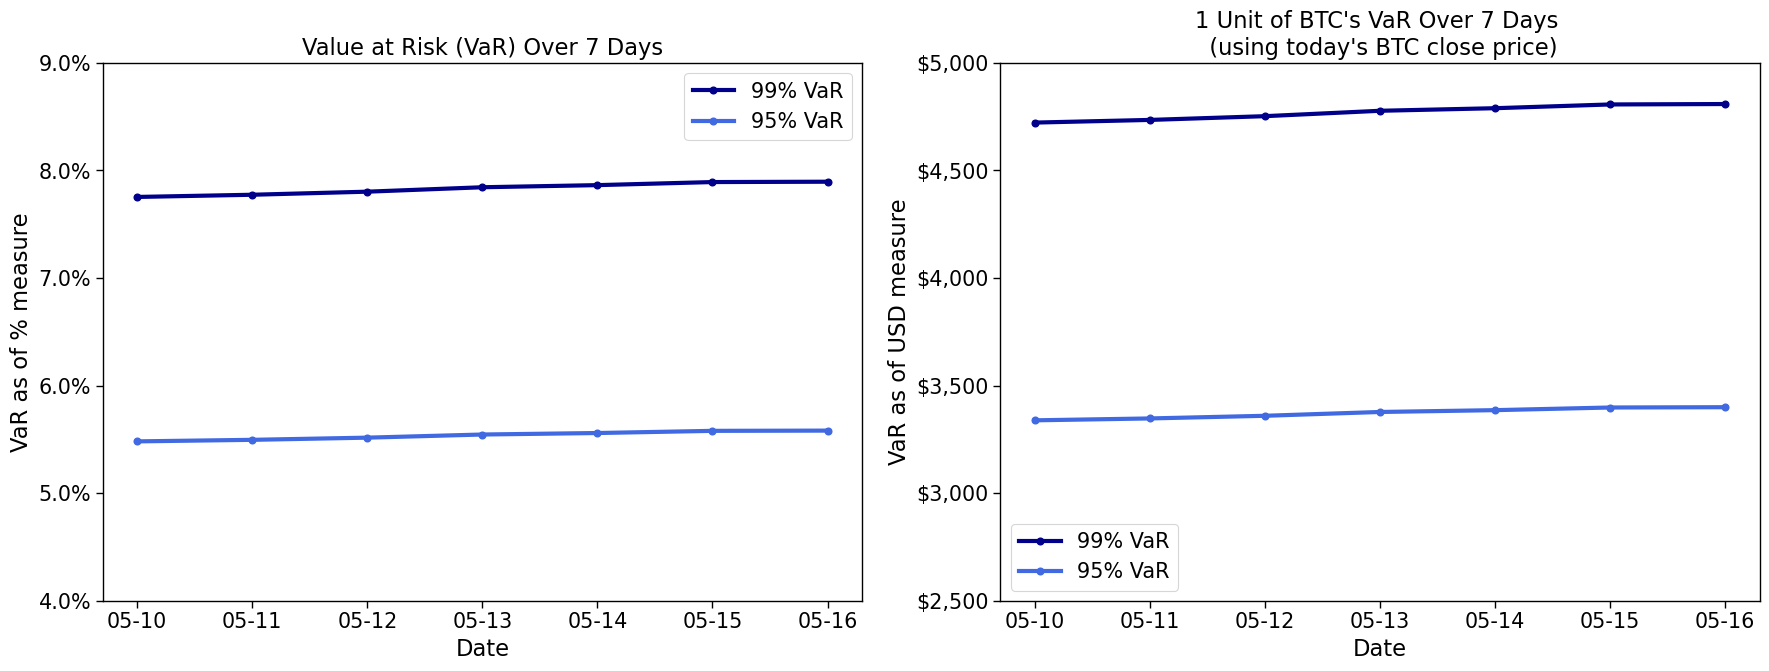

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# First subplot
ax1.plot(forecasts_7d.index, VaRs_99, label='99% VaR', color='darkblue', marker='o', lw=3)
ax1.plot(forecasts_7d.index, VaRs_95, label='95% VaR', color='royalblue', marker='o', lw=3)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_title('Value at Risk (VaR) Over 7 Days')
ax1.set_xlabel('Date')
ax1.set_ylabel('VaR as of % measure')
ax1.set_ylim(4, 9)
ax1.legend()
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Adjust interval as needed
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Second subplot
btc_var_currentprc_99 = VaRs_99 * 0.01 * df.iloc[-1, df.columns.get_loc('Close')]
btc_var_currentprc_95 = VaRs_95 * 0.01 * df.iloc[-1, df.columns.get_loc('Close')]
ax2.plot(forecasts_7d.index, btc_var_currentprc_99, label='99% VaR', color='darkblue', marker='o', lw=3)
ax2.plot(forecasts_7d.index, btc_var_currentprc_95, label='95% VaR', color='royalblue', marker='o', lw=3)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax2.set_title("1 Unit of BTC's VaR Over 7 Days \n (using today's BTC close price)")
ax2.set_xlabel('Date')
ax2.set_ylabel('VaR as of USD measure')
ax2.yaxis.set_major_formatter(tick)
ax2.set_ylim(2500, 5000)
ax2.legend()
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Adjust interval as needed
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.tight_layout()
plt.show()

#  **Application #2: Option Pricing with B-S Model**

Volatility: Derived from above predictions

Risk Free Rate: Current one-month treasury bill from S&P 500

Spot price: Based on Market

Strike price: Based on contracts

Time to maturity: Based on contracts

In [ ]:
# Underlying price (per share): S;
# Strike price of the option (per share): K;
# Time to maturity (years): T;
# Continuously compounding risk-free interest rate: r;
# Volatility: sigma;

## define two functions, d1 and d2 in Black-Scholes model
def d2(S,K,T,r,sigma):
    return(log(S/K)+(r-sigma**2/2.)*T)/sigma*sqrt(T)
def d1(S,K,T,r,sigma):
    return d2(S,K,T,r,sigma)+sigma*sqrt(T)

In [ ]:
## define the call options price function
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

In [ ]:
## define the put options price function
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)*norm.cdf(-d2(S,K,T,r,sigma)) - S*norm.cdf(-d1(S,K,T,r,sigma))

In [ ]:
## input the current Bitcoin price and check if it is a number.
S = input("What is the current Bitcoin price? ");
while True:
    try:
        S = float(S)
        break
    except:
        print("The current Bitcoin price has to be a NUMBER.")
        S = input("What is the current Bitcoin price? ")

## input the strike price and check if it is a number.
K = input("What is the strike price? ");
while True:
    try:
        K = float(K)
        break
    except:
        print("The  strike price has to be a NUMBER.")
        K = input("What is the strike price? ")


## input the expiration_date and calculate the days between today and the expiration date.
while True:
    expiration_date = input("What is the expiration date of the options? (yyyy-mm-dd) ")
    forecast_date = input("What is the forecast date of the options? (yyyy-mm-dd) ")

    try:
        expiration_date = datetime.strptime(expiration_date, "%Y-%m-%d")
        forecast_date = datetime.strptime(forecast_date, "%Y-%m-%d")

    except ValueError as e:
        print("error: %s\nTry again." % (e,))
    else:
        break
T = (expiration_date - forecast_date).days / 365


## input the continuously compounding risk-free interest rate, convert to C.C rate, and check if it is a number
r = input("What is the risk-free interest rate in percentage(%)? (Current 1-month T-bill rate: 5.5%) ");
while True:
    try:
        r = float(r)
        r = -1 * np.log(1/(1+0.01*r))
        break
    except:
        print("The continuously compounding risk-free interest rate has to be a NUMBER.")
        r = input("What is the continuously compounding risk-free interest rate in percentage(%)? ")

KeyboardInterrupt: Interrupted by user

In [ ]:
from pandas import DataFrame

sigma = forecasts_7d.loc[forecast_date, 'Forecasted Volatility'] * 0.01

data = {'Symbol': ['S', 'K', 'T', 'r', 'sigma'],
        'Input': [S, K, T , r , sigma]}
input_frame = DataFrame(data, columns=['Symbol', 'Input'],
                   index=['Underlying price', 'Strike price', 'Time to maturity', 'Risk-free interest rate', 'Volatility'])

input_frame_fmt = input_frame.copy()
input_frame_fmt['Input'] = input_frame_fmt['Input'].round(6)
input_frame_fmt

In [ ]:
## calculate the call / put option price and the greeks of the call / put option
price_forecast = {'Call' : [bs_call(S,K,T,r,sigma)],
                    'Put' : [bs_put(S,K,T,r,sigma)]}
price_frame = DataFrame(price_forecast, columns=['Call','Put'], index=['Price'])

price_frame_fmt = price_frame.copy()
price_frame_fmt = price_frame_fmt.round(2)

price_frame_fmt